In [ ]:
import pandas as pd
import numpy as np
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

## LOADING THE DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
inputs = pd.read_csv('/content/drive/MyDrive/biodata/Local_Data/diabetes_dataset_total.csv')
inputs.head()

,sex,age_group,education,has_insurance,income_group,race,marital_status,general_health,exercise_lately,sleep_time,...,stroke,depression,blood_sugar,prediabetes,currently_insulin,hemoglobin,eye_exam,eye_photo,diabetes_education,diabetes
0,1,4,3,0,0,0,1,1,1,5,...,0,1,0,0,0,0,0,0,0,2
1,0,5,1,1,2,0,3,3,1,8,...,0,0,0,0,0,0,0,0,0,2
2,1,2,3,1,3,0,1,1,1,8,...,0,0,2,0,0,0,0,0,0,0
3,1,5,3,1,4,0,0,3,1,4,...,0,0,1,0,0,0,0,0,0,0
4,1,5,2,1,1,0,2,2,0,9,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
inputs.dtypes

sex                     int64
age_group               int64
education               int64
has_insurance           int64
income_group            int64
race                    int64
marital_status          int64
general_health          int64
exercise_lately         int64
sleep_time              int64
smoking                 int64
heavy_drinker           int64
height                float64
weight                float64
bmi                   float64
bmi_groups              int64
has_doctor              int64
affords_doctor          int64
last_checkup            int64
asthma_history          int64
stroke                  int64
depression              int64
blood_sugar             int64
prediabetes             int64
currently_insulin       int64
hemoglobin              int64
eye_exam                int64
eye_photo               int64
diabetes_education      int64
diabetes                int64
dtype: object

Τα περισσοτερα features με τα οποία δουλεύουμε είναι κατηγορικές μεταβλητές. Αυτό στην πράξη εισάγει κάποιες δυσκολίες, πχ αποκλύει τις περισσότερες από τις πιο δημοφιλής μεθόδους clustering, οι οποίες θα μπορούσαν να χρησιμοποιηθούν για την εύρεση χρήσιμων patterns σε υποσύνολα των δεδομένων.
Επιπλέον, η κατηγοριοποίηση των περισσότερων μεταβλητών σε bins (κατά τη δειάρκεια της τηλεφωνικής δειγματοληψίας) σημαίνει πως το granularity των δεδομένων μας δεν είναι το επιθυμητό και σημαντικο ποσοστό του variance των κατανομών χάθηκε. Αυτό το έξτρα variance δυνητικά θα μπορούσε να συμβάλει καταλυτικά στην δημιουργία ενός μοντέλου με καλύτερη προβλεπτική ικανότητα.



# Class Imbalance

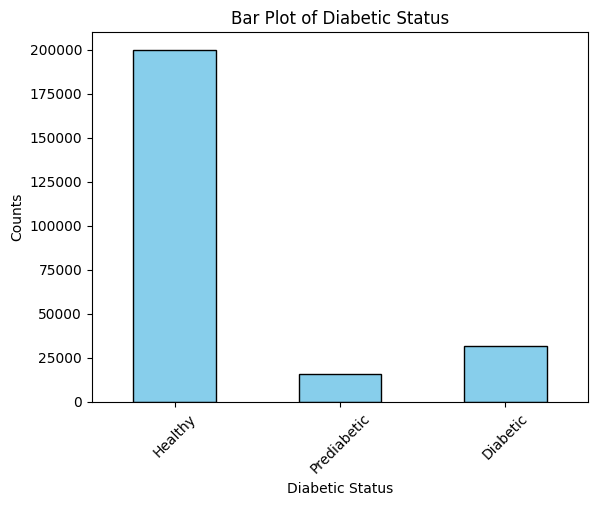

In [ ]:
value_counts = inputs['diabetes'].value_counts().sort_index()


# Custom labels
labels = {0: 'Healthy', 1: 'Prediabetic', 2: 'Diabetic'}

# Create bar plot
ax = value_counts.plot(kind='bar', color='skyblue', edgecolor = 'black')
plt.xlabel('Diabetic Status')
plt.ylabel('Counts')
plt.title('Bar Plot of Diabetic Status')

# Set custom tick labels
ax.set_xticklabels([labels.get(x, x) for x in value_counts.index], rotation=45)

# Show plot
plt.show()









Όπως είδαμε και στο κομμάτι δημιουργίας του dataset, υπάρχει έντονη ανισσοροπία των κλάσεων, με την κλάση των υγειών να έχει σημαντικά περισσότερα δείγματα από τις υπόλοιπες. Δείξαμε, πως ο εμπλουτισμός της κλάσης των προδιαβητικών με δεδομένα από άλλες χρονιές, βελτιώνει το recall του μοντέλου.

## **Univariate Analysis**

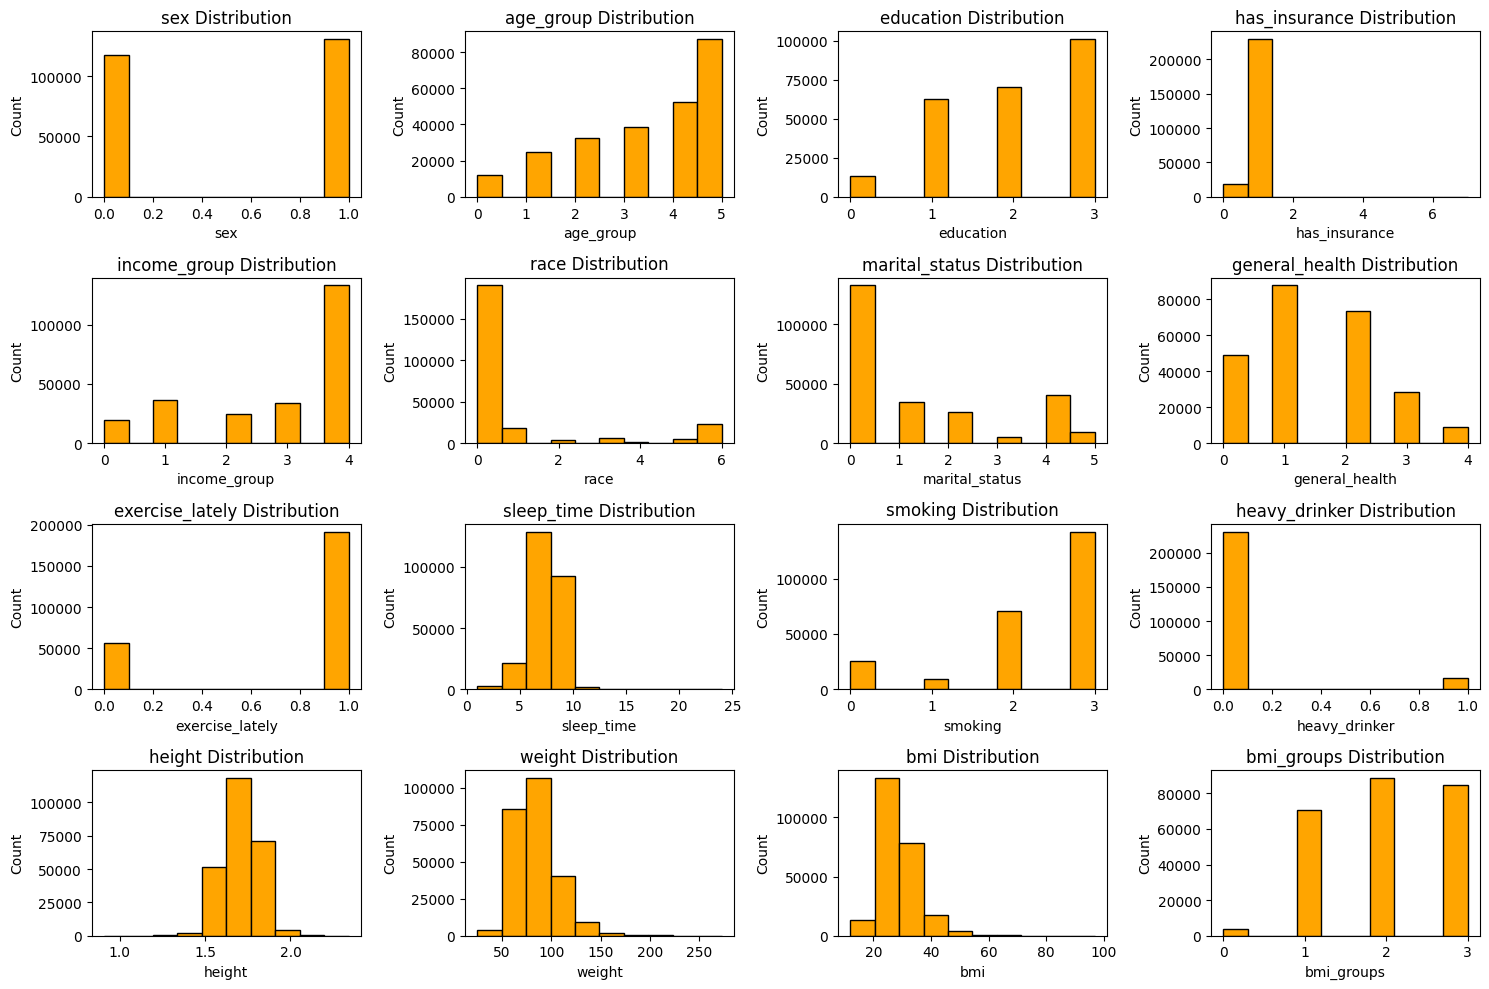

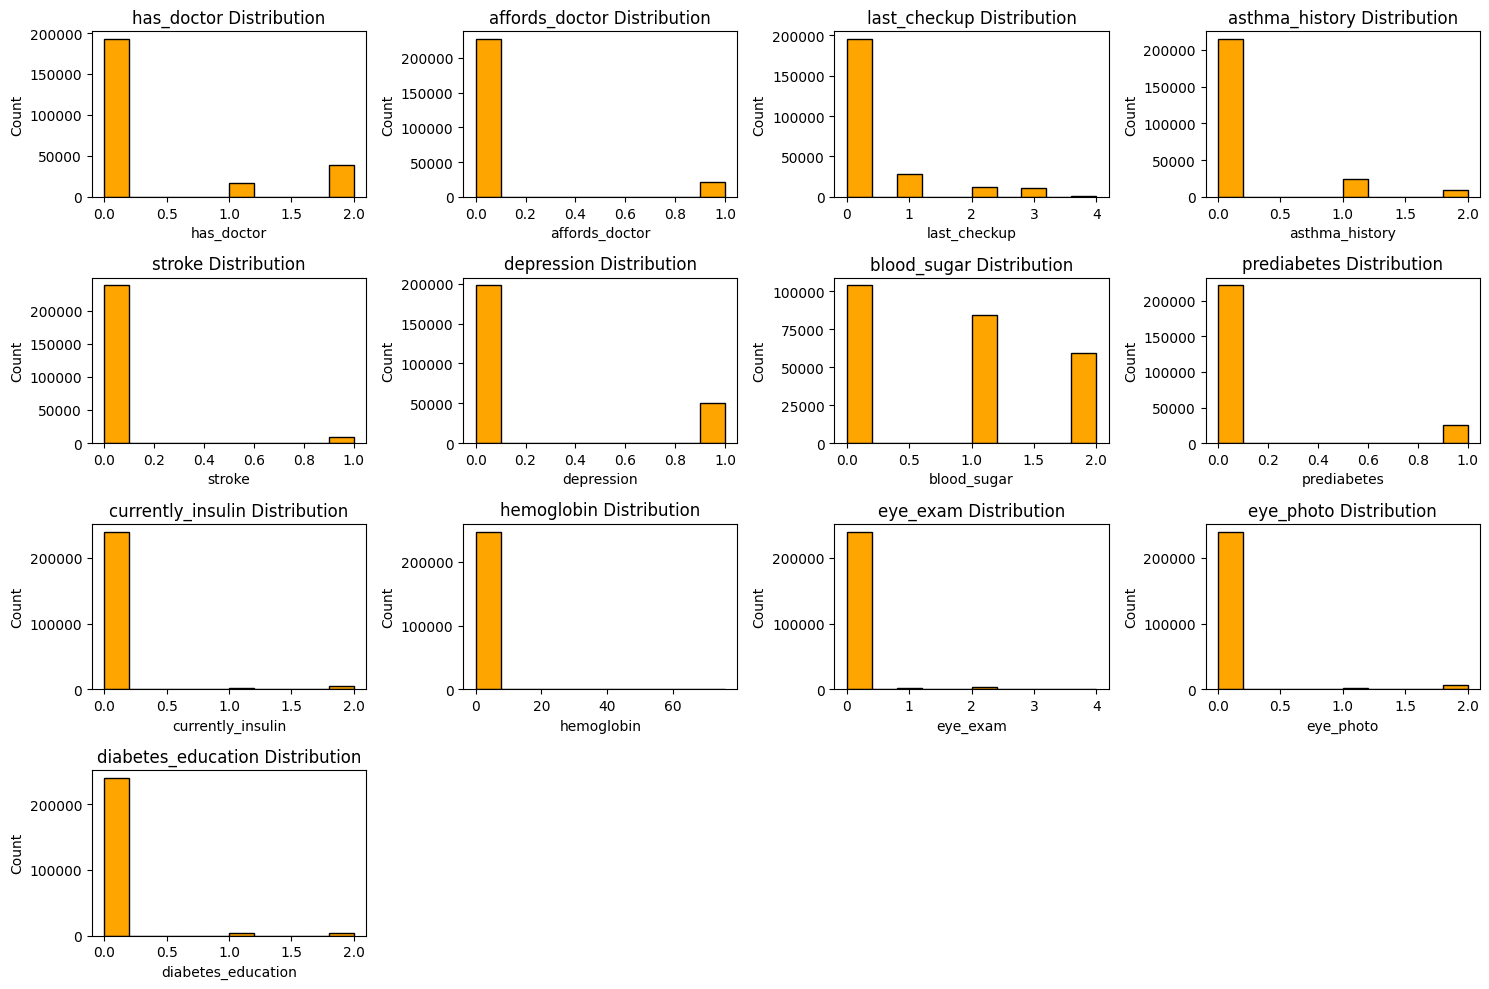

In [ ]:
# Adjust the plotting to handle more columns and print 4 plots per figure
columns_to_plot = inputs.columns[:-1]
num_columns = len(columns_to_plot)
plots_per_figure = 16

# Function to plot histograms
def plot_histograms(start_idx, end_idx, df, columns):
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(columns[start_idx:end_idx], 1):
        plt.subplot(4, 4, i)
        plt.hist(df[column],  edgecolor='black',color='orange')
        plt.title(f'{column} Distribution')
        plt.xlabel(column)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Loop through the columns and plot in sets of 16
for i in range(0, num_columns, plots_per_figure):
    plot_histograms(i, min(i + plots_per_figure, num_columns), inputs, columns_to_plot)

Κάποιες από τις επεξηγηματικές μεταβλητές παρουσιάζουν κατανομή η οποία προσομοιάζει την κανονική. Τέτοιες είναι το BMI, ύψος και βάρος.

Ενδιαφέρον παρουσιάζει η κατανομή των Age Groups, η οποία είναι μετατοπισμένη προς τις κατηγορίες 4 και 5, που αντιπροσωπεύουν ηλικίες άνω των 55 ετών. Αυτό ίσως να οφείλεται στον τρόπο δειγματοληψίας μέσω τηλεφώνου: νεότερες γενίες πιθανότατα να συμμετήχαν πιο εύκολα σε κάποια έρευνα πχ μέσω διαδικτύου. Επιπλέον, στην κατηγορία Race υπάρχει υπερεκπροσώπηση της κατηγορίας των Λευκών, με άλλες εθνοτικές ομάδες όπως οι Αφροαμερικάνοι και οι Λατίνοι να μην εμφανίζονται σε αντίστοιχο ποσοστό. Τέτοιου είδους ανισσοροπίες στα δεδομένα, εισάγουν bias στα δεδομένα μας.

## **Bivariate Analysis**

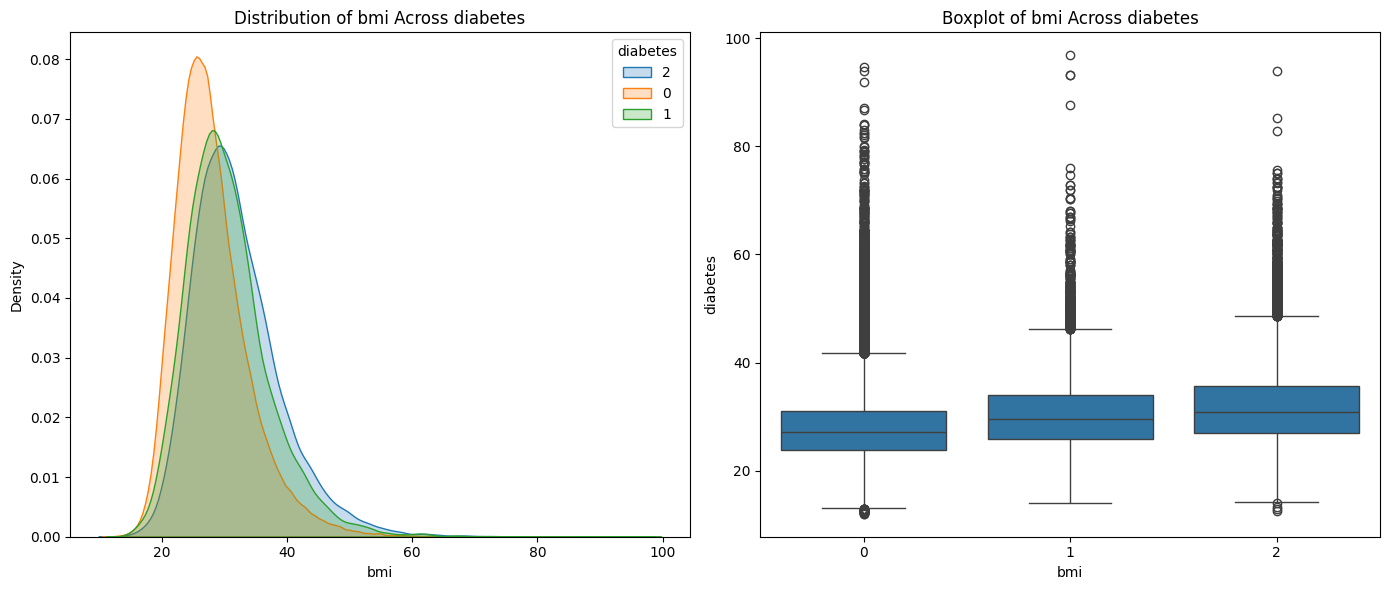

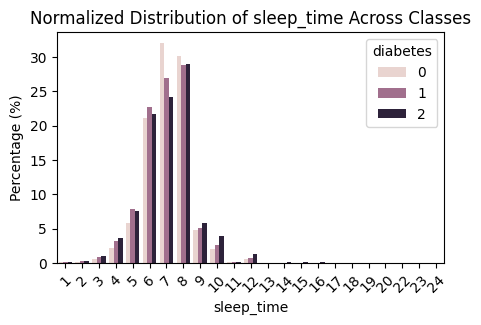

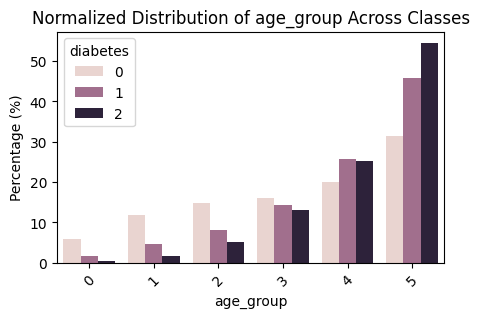

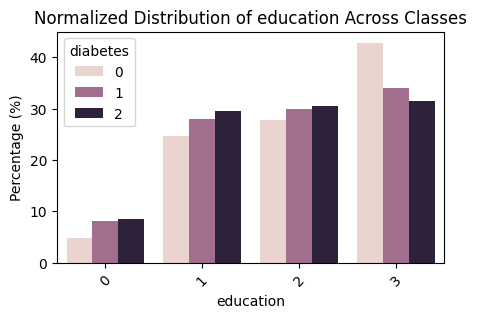

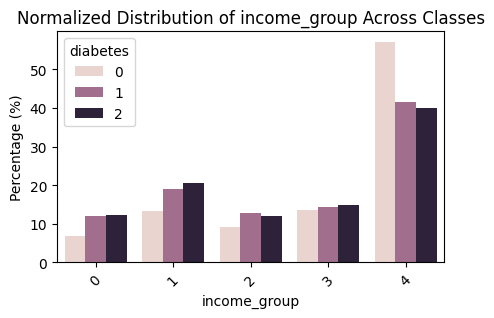

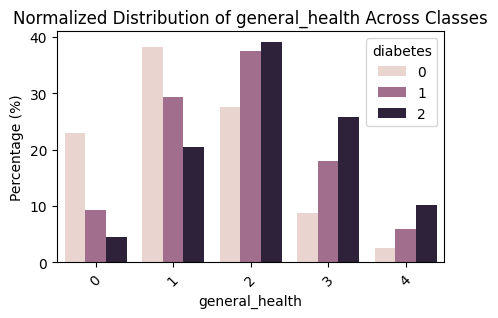

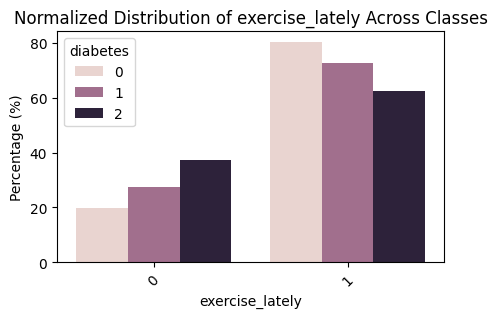

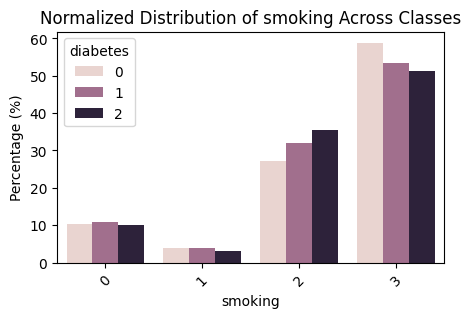

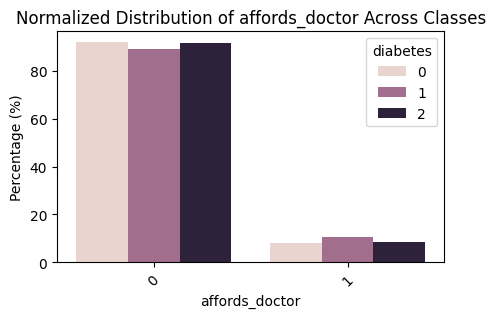

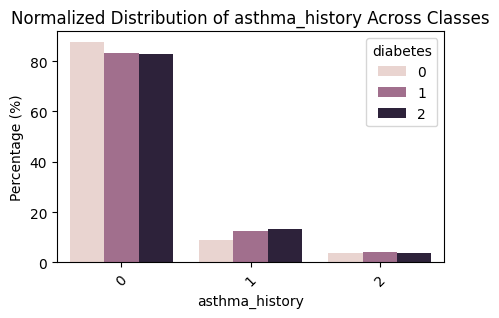

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_density(data, feature, category):
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 6))

    for cat in data[category].unique():
        subset = data[data[category] == cat]
        sns.kdeplot(subset[feature], label=cat, fill=True, ax=axs1)

    sns.boxplot(x=category, y=feature, data=data, ax=axs2)

    axs1.set_title(f'Distribution of {feature} Across {category}')
    axs1.set_xlabel(f'{feature}')
    axs1.set_ylabel('Density')
    axs1.legend(title=category)

    axs2.set_title(f'Boxplot of {feature} Across {category}')
    axs2.set_xlabel(f'{feature}')
    axs2.set_ylabel(category)

    plt.tight_layout()
    plt.show()


def plot_normalized_categorical(data, feature, category):
    plt.figure(figsize=(5, 3))

    # Calculate the count normalized by the total counts in each category
    count_data = (data.groupby([category])[feature]
                    .value_counts(normalize=True)  # Normalize counts within each category
                    .rename('percentage')
                    .mul(100)  # Convert to percentage
                    .reset_index()
                    .sort_values(feature))

    # Plot using seaborn
    sns.barplot(x=feature, y='percentage', hue=category, data=count_data)
    plt.title(f'Normalized Distribution of {feature} Across Classes')
    plt.xlabel(f'{feature}')
    plt.ylabel('Percentage (%)')
    plt.legend(title=category)
    plt.xticks(rotation=45)
    plt.show()


features_continuous = [ 'bmi']
features_categorical = ['sleep_time','age_group', 'education', 'income_group', 'general_health', 'exercise_lately', 'smoking', 'affords_doctor', 'asthma_history']

for feature in features_continuous:
    plot_density(inputs, feature, 'diabetes')

for feature in features_categorical:
    plot_normalized_categorical(inputs, feature, 'diabetes')


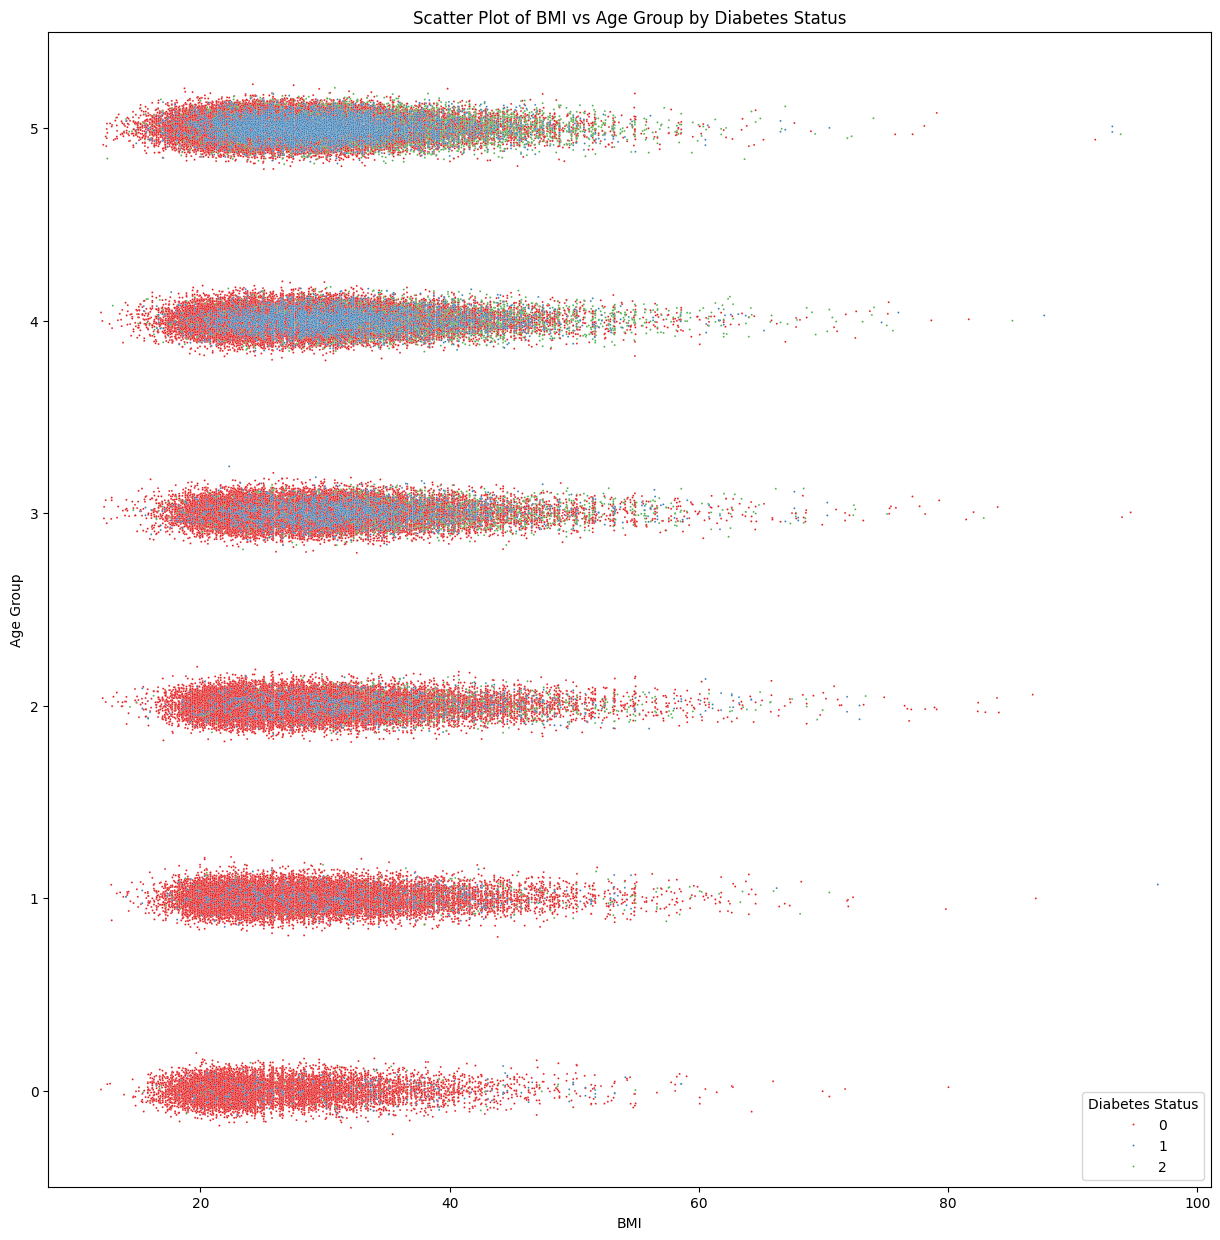

In [ ]:
import seaborn as sns

# Define the categorical column that will determine the color of the points
color_column = 'diabetes'
jittered_age_group = inputs['age_group'] + np.random.normal(0, 0.05, size=len(inputs))
plt.figure(figsize=(15,15))
# Create a scatter plot with different colors for each category
sns.scatterplot(x='bmi', y=jittered_age_group, hue=color_column, data=inputs, palette='Set1', s=2)

# Adding labels and title

plt.xlabel('BMI')
plt.ylabel('Age Group')
plt.title('Scatter Plot of BMI vs Age Group by Diabetes Status')
plt.legend(title='Diabetes Status')
plt.show()

<ipython-input-30-a3a3984421e8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Healthy', 'Prediabetic', 'Diabetic'])


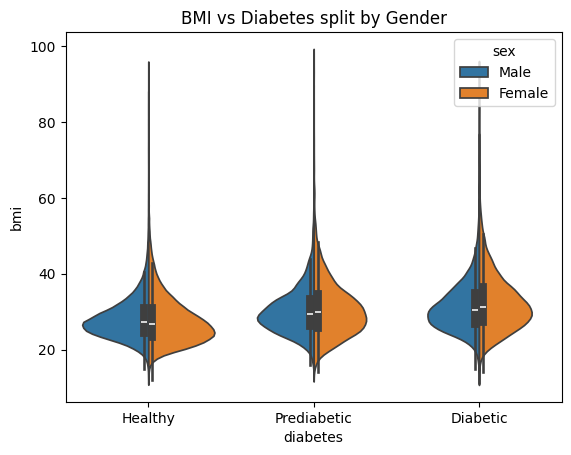

In [ ]:
ax = sns.violinplot(x='diabetes', y='bmi', hue='sex', split=True, data=inputs)
plt.title('BMI vs Diabetes split by Gender')


handles, labels = ax.get_legend_handles_labels()
labels = ['Male' if label == '0' else 'Female' for label in labels]
ax.legend(handles, labels, title='sex')
ax.set_xticklabels(['Healthy', 'Prediabetic', 'Diabetic'])

plt.show()

Interaction between gender vs bmi vs diabetes

<ipython-input-31-d42e20823816>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Healthy', 'Prediabetic', 'Diabetic'])


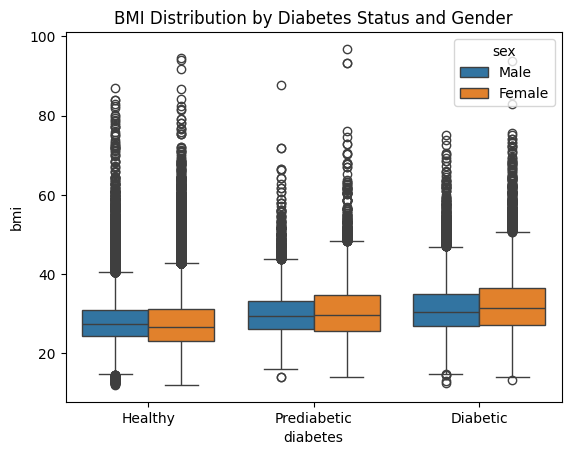

In [ ]:
# Interaction between gender, BMI and diabetes
ax = sns.boxplot(x='diabetes', y='bmi', hue='sex', data=inputs)
plt.title('BMI Distribution by Diabetes Status and Gender')
handles, labels = ax.get_legend_handles_labels()
labels = ['Male' if label == '0' else 'Female' for label in labels]
ax.legend(handles, labels, title='sex')
ax.set_xticklabels(['Healthy', 'Prediabetic', 'Diabetic'])
plt.show()

Στα παραπάνω διαγράματα, διαφένεται ένα βασικό πρόβλημα του συγκεκριμένου dataset, το οποίο δυσχεραίνει σημαντικά τη διαδικασία ταξινόμησης. Συγκεκριμένα, τα διάφορα features, εμφανίζουν μεγάλο βαθμό αλληλοεπικάλυψης μεταξύ τους για διαφορετικές τιμές της εξόδου (που στην προκειμένη περίπτωση είναι η νόσηση η όχι από διαβήτη η προδιαβήτη). Επομένως, οι discriminative αλγόριθμοι δε μπορούν να διακρίνουν το όριο απόφασης, ώστε να παράγουν ασφαλείς προβλέψεις.

Χαρακτηριστικό παράδειγμα αποτελεί το bmi, το οποίο αν και έχει διάφορα επιθυμητα χαρακτηριστικά όπως μεγάλο feature importance όταν χρησιμοποείται σε μοντέλα και υψηλή τιμή του συντελεστή συσχέτισης, εξακολουθεί να παρουσιάζει μεγάλη επικάλυψη στις τρεις κατανομές για τις 3 κλάσεις της μεταβλητής εξόδου.

Θα επιχειρήσουμε σε αυτό το σημείο να δώσουμε μια πιθανή εξήγηση για αυτό το φαινόμενο. Από την ιατρική βιβλιογραφία, είναι κοινα αποδεκτό ότι η κακή διατροφή και παχυσαρκία αυξάνουν την πιθανότητα εμφάνισης διαβήτη. Ωστόσο, τα δεδομένα μας αποτελούν ένα στιγμυότυπο στη ζωή ενός ατόμου. Δεν διαθετουμε δεδομένα που παρακολουθούν έναν ασθενή σε βάθος χρόνου. Επομένως, δεν αποτυπώνεται με κάποιον τρόπο πως ένα άτομο που αυτή τη στιγμή έχει επιβαρυντικο lifestyle αλλά είναι υγιές, μπορεί να εμφανίσει στο μέλλον διαβήτη. Αντίστοιχα, ένα άτομο που έχει διαβήτη αλλά έχει προσαρμώσει τον τρόπο ζωής του σε υγιεινές συνήθειες, μπορεί να μετακινεί τα δεδομένα με τέτοιο τρόπο ώστε το "προφανές" συμπέρασμα ότι κακό lifestyle προκαλέι διαβήτη να μην μεταφράζεται στο μοντέλο μας.  

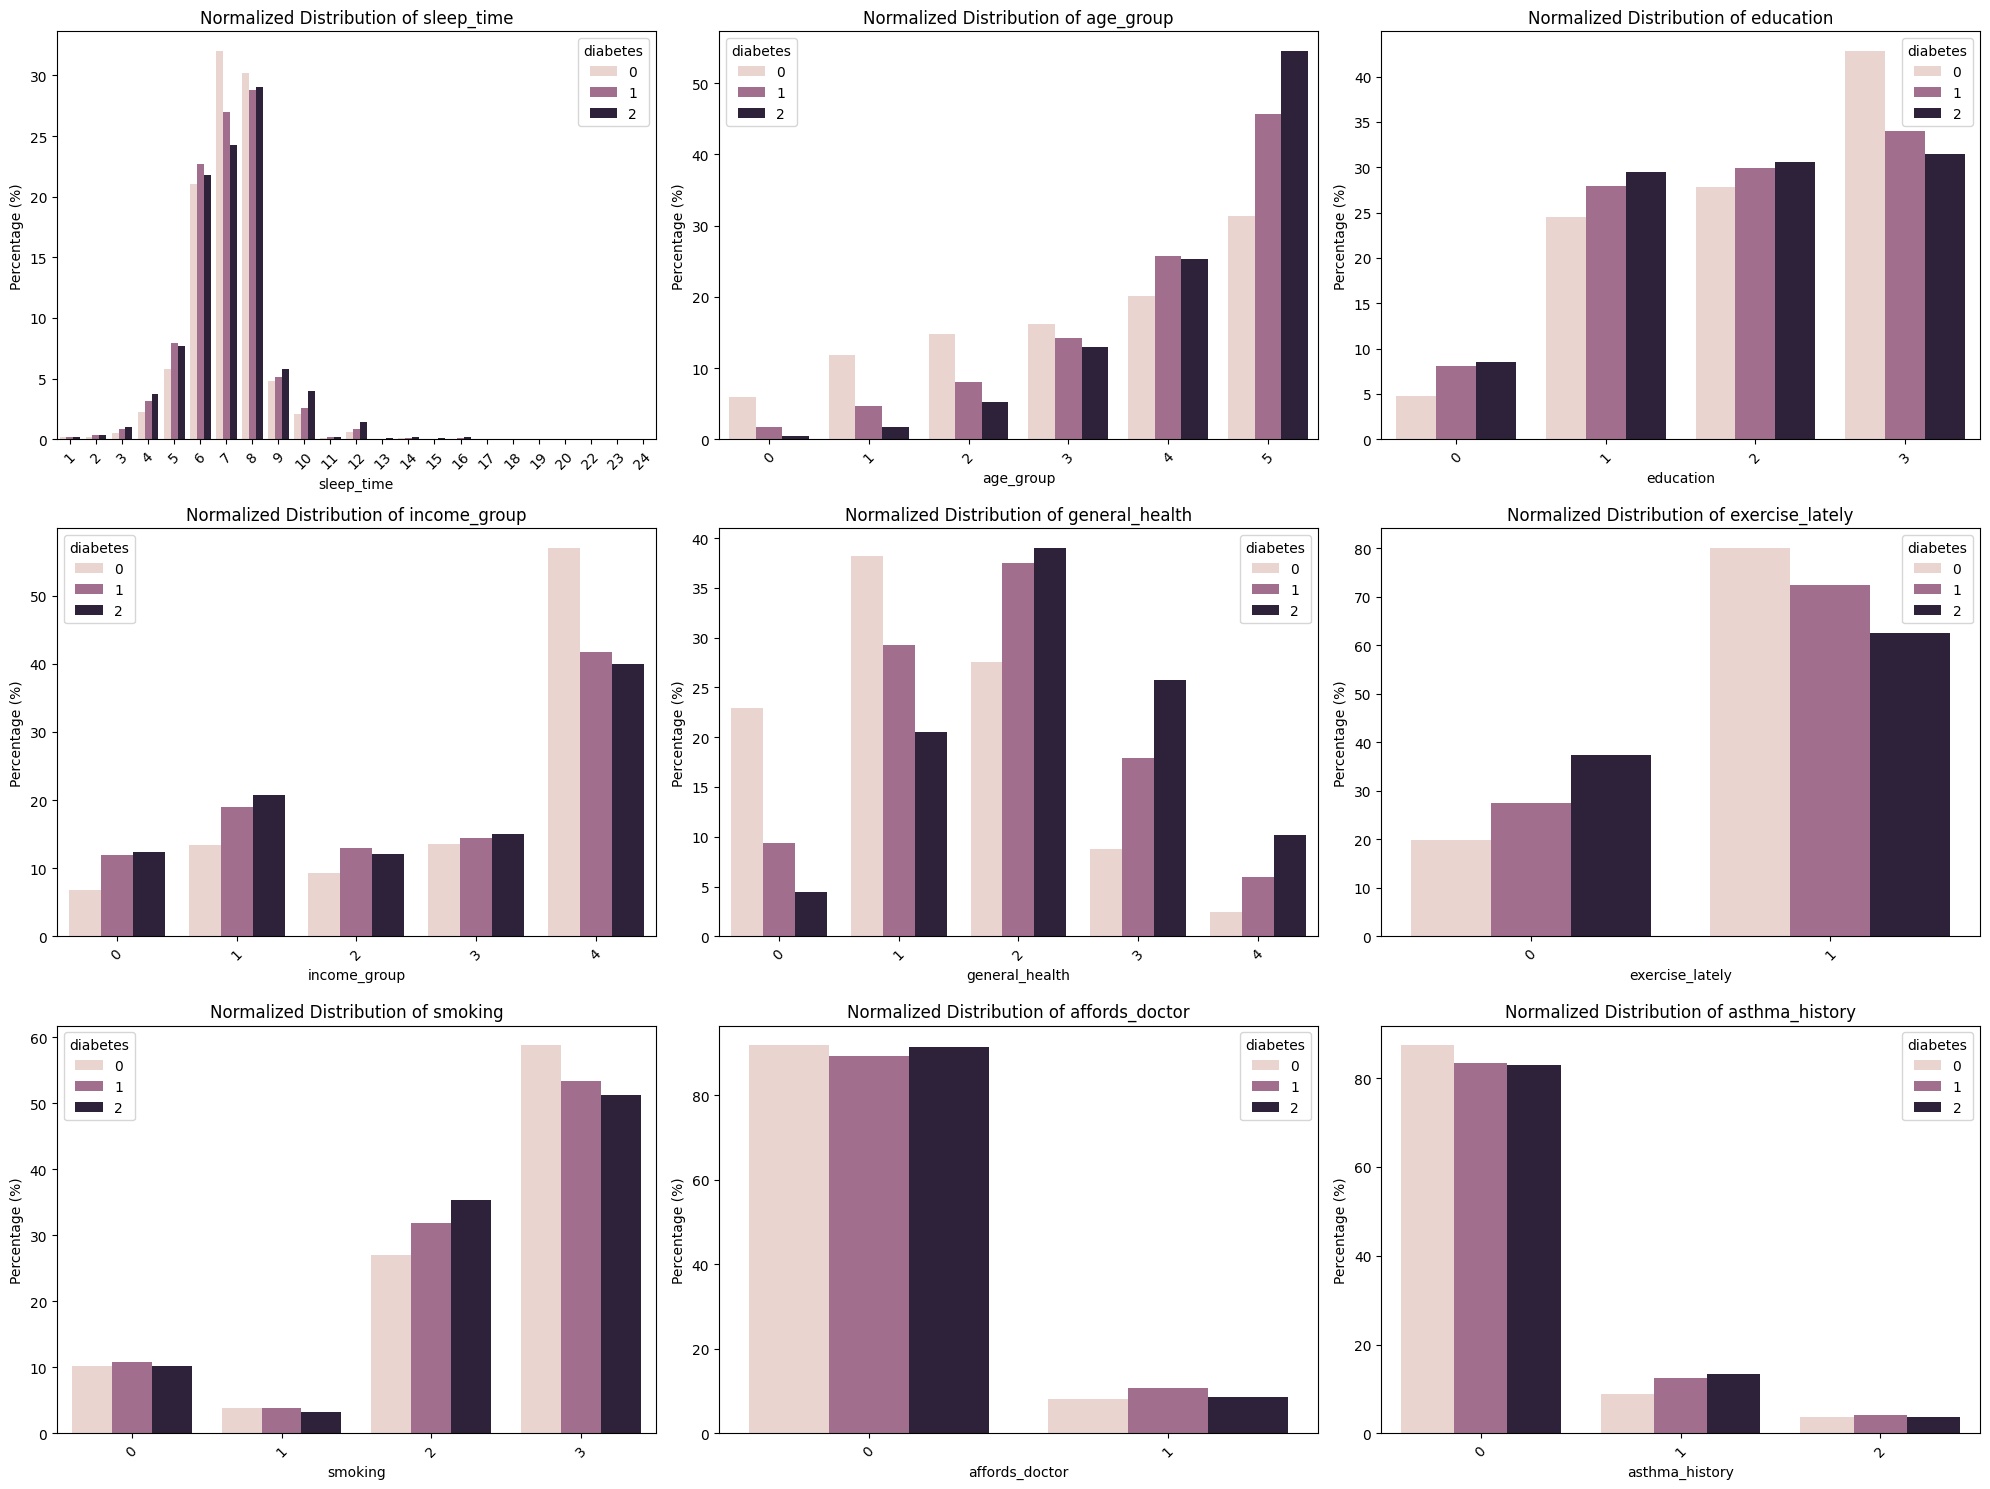

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_normalized_categorical(data, feature, category, ax):
    # Calculate the count normalized by the total counts in each category
    count_data = (data.groupby([category])[feature]
                    .value_counts(normalize=True)  # Normalize counts within each category
                    .rename('percentage')
                    .mul(100)  # Convert to percentage
                    .reset_index()
                    .sort_values(feature))

    # Plot using seaborn
    sns.barplot(x=feature, y='percentage', hue=category, data=count_data, ax=ax)
    ax.set_title(f'Normalized Distribution of {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Percentage (%)')
    ax.legend(title=category)
    ax.tick_params(axis='x', rotation=45)

features_categorical = ['sleep_time', 'age_group', 'education', 'income_group', 'general_health', 'exercise_lately', 'smoking', 'affords_doctor', 'asthma_history']

num_features = len(features_categorical)
cols = 3
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features_categorical):
    plot_normalized_categorical(inputs, feature, 'diabetes', axes[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Correlation and Chi-squared tests

## Multicollinearity

In [ ]:
def calculate_vif(data):
    data = data.select_dtypes(include=[np.number])
    #  intercept
    data = add_constant(data)
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

In [ ]:
multicol = calculate_vif(inputs).sort_values(by='VIF', ascending=False)
multicol[multicol['VIF']>5]

,variables,VIF
0,const,5061.153045
14,weight,68.348726
15,bmi,52.721388
13,height,19.546290
28,eye_photo,14.569118
25,currently_insulin,12.409035
29,diabetes_education,8.575374


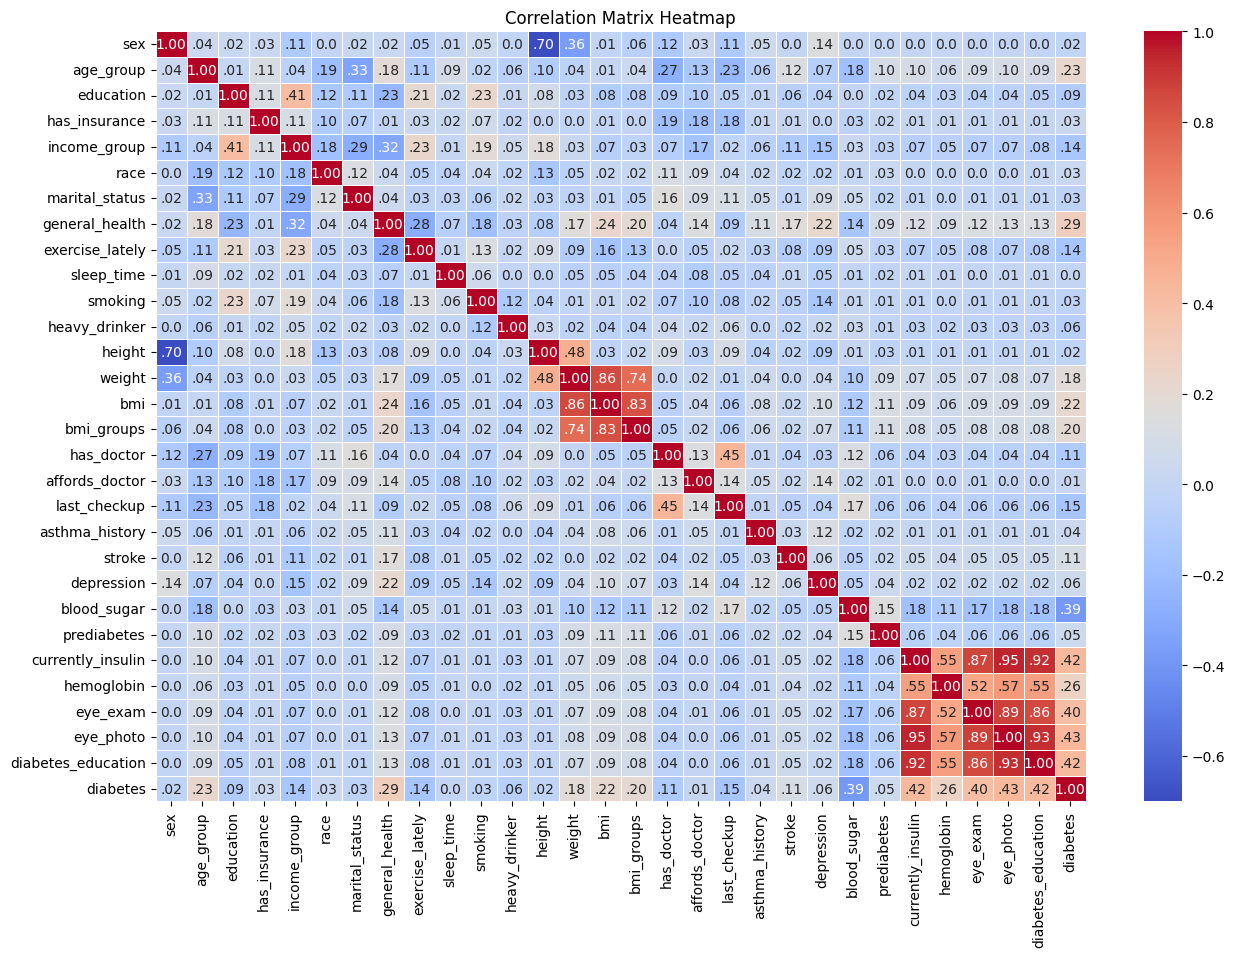

In [ ]:

# Compute the correlation matrix
correlation_matrix = inputs.corr()

# Custom annotation format function
def custom_fmt(x, pos):
    return f"{x:.2f}".lstrip('0').lstrip('-0') if x != 0 else "0.0"

# Graph I
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.4, fmt='.2f', annot_kws={"size": 10})
plt.title("Correlation Matrix Heatmap")

# Update annotations with custom format
for text in plt.gca().texts:
    text.set_text(custom_fmt(float(text.get_text()), None))

plt.show()


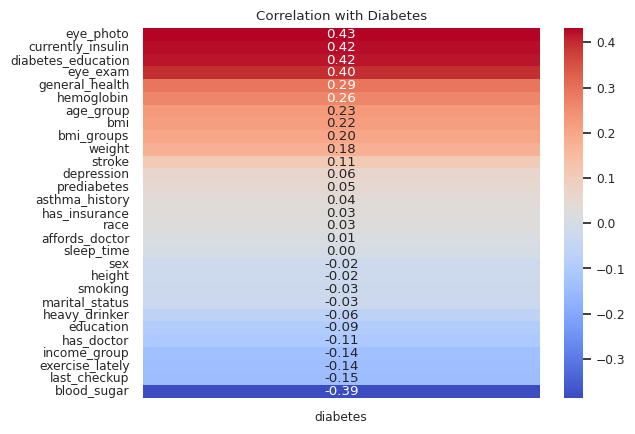

In [ ]:
corr = inputs.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

Επεξηγηματικές μεταβλητές όπως το eye_photo, currently_insulin, eye_exam εμφανίζουν σημαντικό correlation με την μεταβλητή εξόδου, διότι σχετίζονται για εξετάσεις και θεραπείες που άτομα με διάγνωση διαβήτη η κίνδυνο διαβήτη θα κάνουν πιο συχνά από το μέσο άτομο.

In [ ]:
l

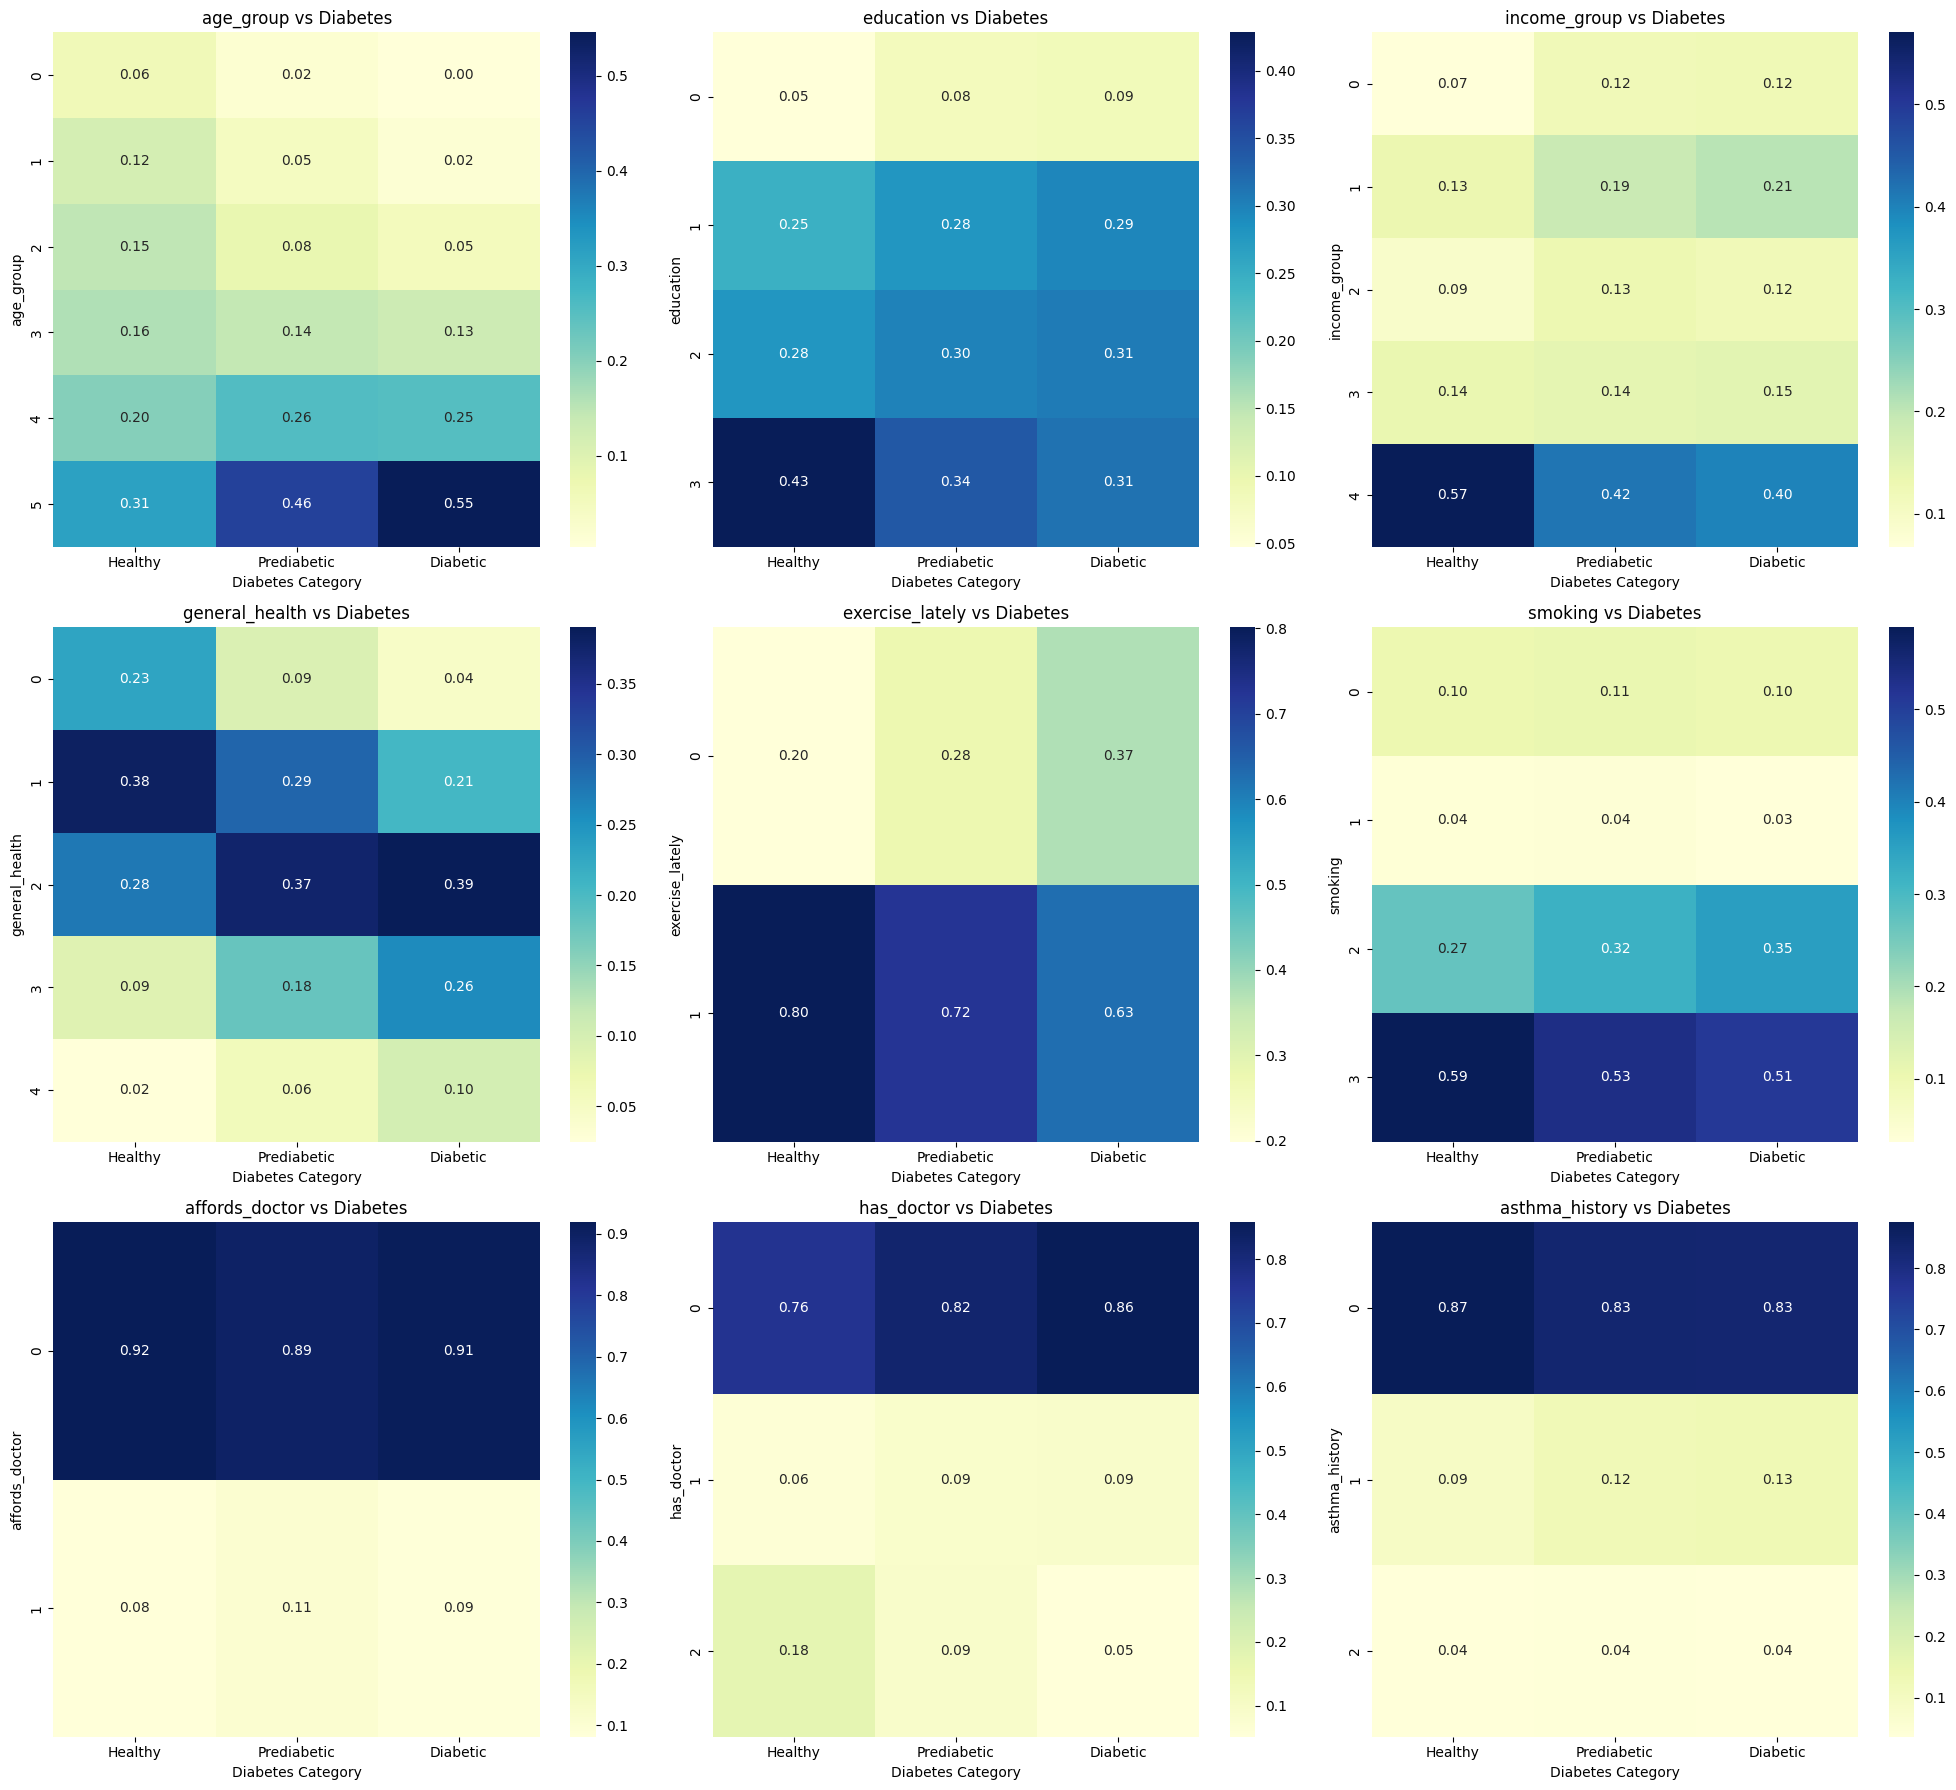

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Labels for diabetes categories
diabetes_labels = ['Healthy', 'Prediabetic', 'Diabetic']
categorical_columns = [ 'age_group', 'education', 'income_group', 'general_health',
                       'exercise_lately', 'smoking', 'affords_doctor', 'has_doctor','asthma_history']
# Function to plot heatmap and perform chi-square test
def analyze_categorical_column(column_name, ax):
    # Create contingency table
    contingency_table = pd.crosstab(inputs[column_name], inputs['diabetes'])

    # Create normalized contingency table for heatmap
    contingency_table_normalized = pd.crosstab(inputs[column_name], inputs['diabetes'], normalize='columns')

    # Plot the normalized heatmap
    sns.heatmap(contingency_table_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=diabetes_labels, yticklabels=contingency_table.index, ax=ax)
    ax.set_xlabel('Diabetes Category')
    ax.set_ylabel(column_name)
    ax.set_title(f'{column_name} vs Diabetes')

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each categorical column and perform the analysis
for i, column in enumerate(categorical_columns):
    analyze_categorical_column(column, axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


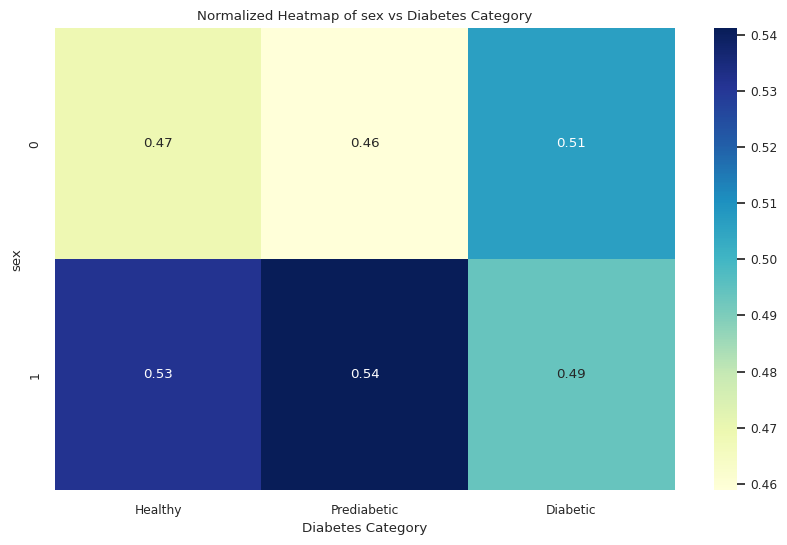

Column: sex
Chi-Square Statistic: 168.29531639186882
P-Value: 2.8519137063258024e-37
Degrees of Freedom: 2
Expected Frequencies:
[[ 94596.12064718   7407.40629973  15091.47305309]
 [105427.87935282   8255.59370027  16819.52694691]]
There is a significant association between sex and diabetes type (reject H0)

--------------------------------------------------------------------------------



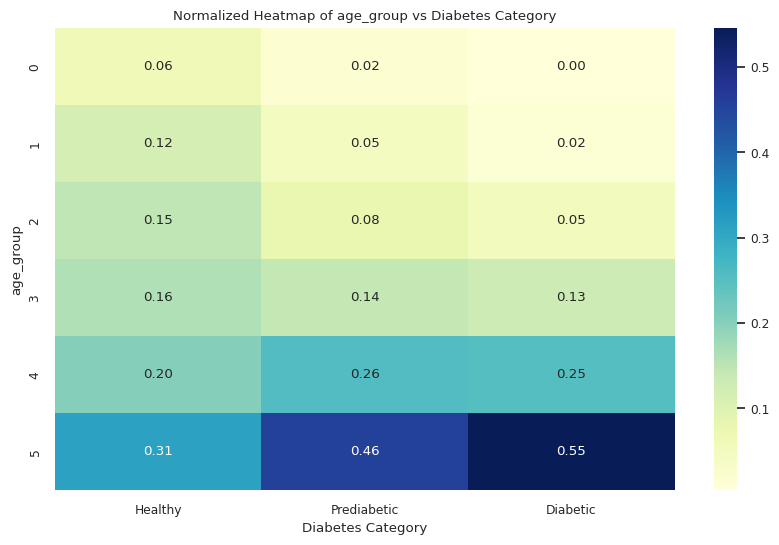

Column: age_group
Chi-Square Statistic: 13080.90158007652
P-Value: 0.0
Degrees of Freedom: 10
Expected Frequencies:
[[ 9954.42502767   779.48725757  1588.08771476]
 [20128.58740378  1576.18118078  3211.23141544]
 [26127.74015945  2045.94845677  4168.31138378]
 [31171.19702098  2440.87938917  4972.92358985]
 [42235.61880144  3307.28561216  6738.09558639]
 [70406.43158668  5513.21810354 11232.35030978]]
There is a significant association between age_group and diabetes type (reject H0)

--------------------------------------------------------------------------------



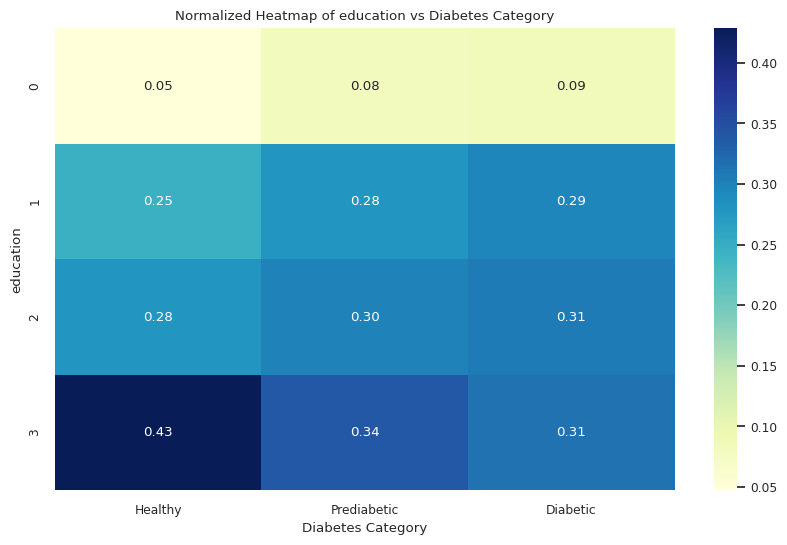

Column: education
Chi-Square Statistic: 2420.7440367980716
P-Value: 0.0
Degrees of Freedom: 6
Expected Frequencies:
[[10886.69304275   852.48906696  1736.81789029]
 [50816.68540134  3979.23120946  8107.0833892 ]
 [56672.03945105  4437.73824102  9041.22230793]
 [81648.58210486  6393.54148256 13025.87641257]]
There is a significant association between education and diabetes type (reject H0)

--------------------------------------------------------------------------------



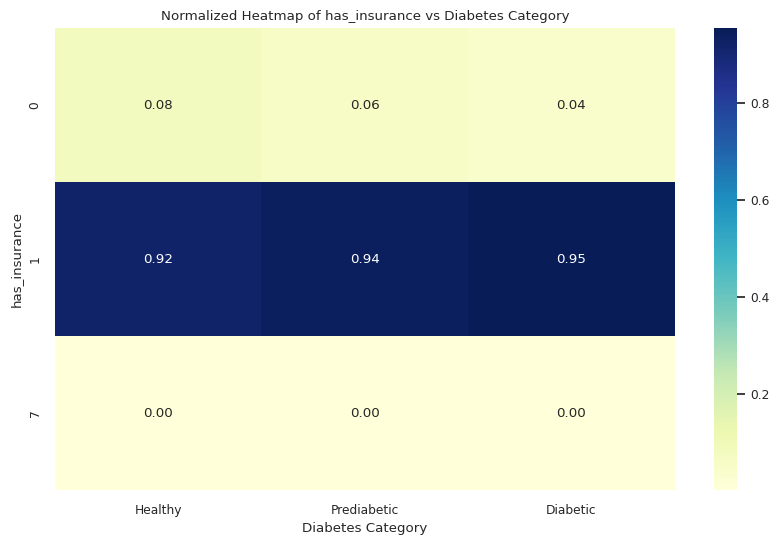

Column: has_insurance
Chi-Square Statistic: 550.9459527077896
P-Value: 6.386444523157225e-118
Degrees of Freedom: 4
Expected Frequencies:
[[1.46496951e+04 1.14715322e+03 2.33715165e+03]
 [1.85109327e+05 1.44950976e+04 2.95315750e+04]
 [2.64977391e+02 2.07492145e+01 4.22733948e+01]]
There is a significant association between has_insurance and diabetes type (reject H0)

--------------------------------------------------------------------------------



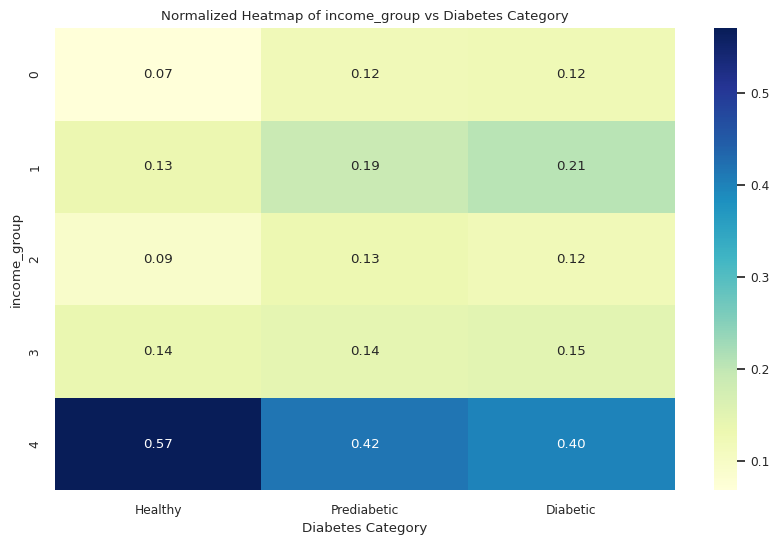

Column: income_group
Chi-Square Statistic: 5019.234649503312
P-Value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[ 15674.0589504    1227.3666427    2500.5744069 ]
 [ 29456.11470206   2306.57883343   4699.30646451]
 [ 19671.33983312   1540.37613389   3138.28403299]
 [ 27532.60504528   2155.95724925   4392.43770547]
 [107689.88146916   8432.72114072  17180.39739012]]
There is a significant association between income_group and diabetes type (reject H0)

--------------------------------------------------------------------------------



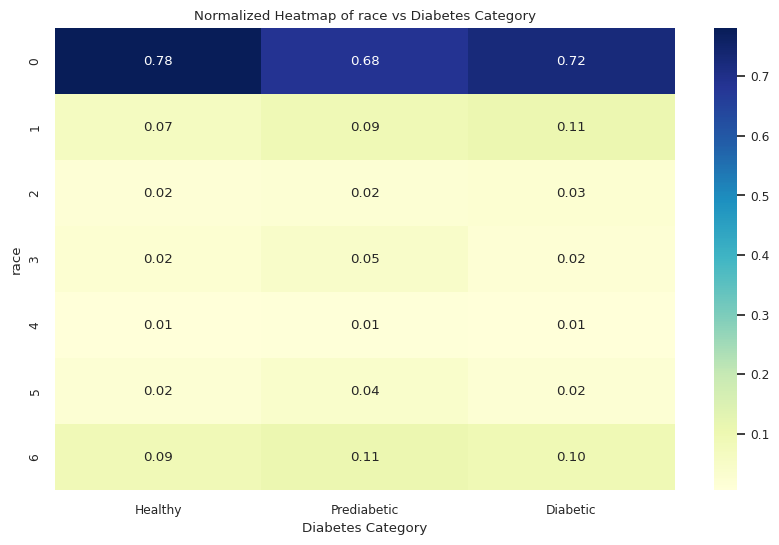

Column: race
Chi-Square Statistic: 1920.6378943641039
P-Value: 0.0
Degrees of Freedom: 12
Expected Frequencies:
[[1.53488961e+05 1.20190457e+04 2.44869928e+04]
 [1.44800450e+04 1.13386866e+03 2.31008637e+03]
 [3.40754462e+03 2.66829837e+02 5.43625546e+02]
 [4.86492027e+03 3.80950517e+02 7.76129218e+02]
 [1.15442894e+03 9.03982544e+01 1.84172808e+02]
 [4.40040197e+03 3.44576131e+02 7.02021894e+02]
 [1.82276978e+04 1.42733087e+03 2.90797136e+03]]
There is a significant association between race and diabetes type (reject H0)

--------------------------------------------------------------------------------



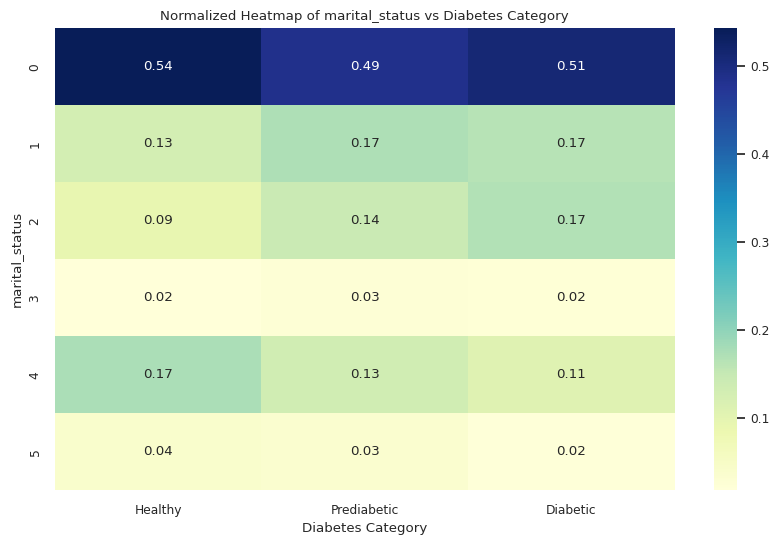

Column: marital_status
Chi-Square Statistic: 3311.594509876255
P-Value: 0.0
Degrees of Freedom: 10
Expected Frequencies:
[[107139.73024015   8389.64121681  17092.62854304]
 [ 27599.65725087   2161.20781266   4403.13493647]
 [ 21205.46198273   1660.5064944    3383.03152287]
 [  3851.86646096    301.62272716    614.51081188]
 [ 32691.58558631   2559.93433307   5215.48008061]
 [  7535.69847899    590.08741589   1202.21410512]]
There is a significant association between marital_status and diabetes type (reject H0)

--------------------------------------------------------------------------------



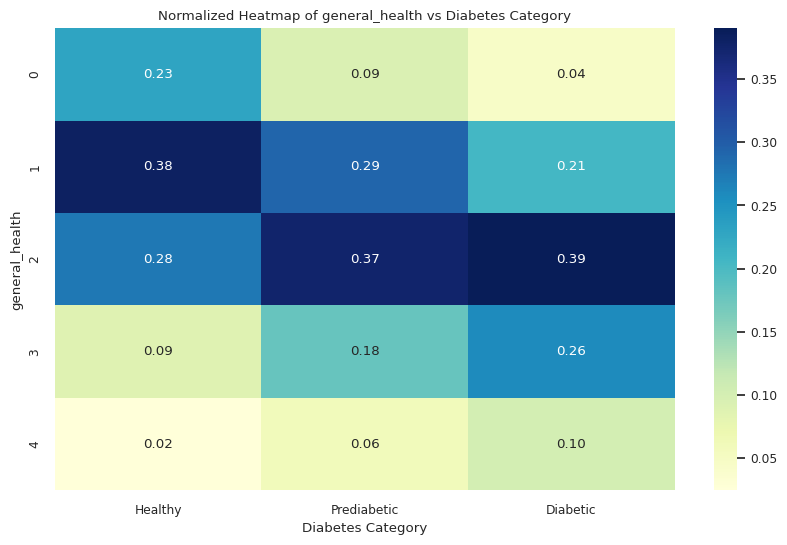

Column: general_health
Chi-Square Statistic: 21979.828381033367
P-Value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[39456.58762995  3089.67189961  6294.74047044]
 [70715.03330398  5537.3833472  11281.58334882]
 [59378.36341166  4649.65857156  9472.97801679]
 [23075.6530182   1806.95293177  3681.39405003]
 [ 7398.36263621   579.33324986  1180.30411393]]
There is a significant association between general_health and diabetes type (reject H0)

--------------------------------------------------------------------------------



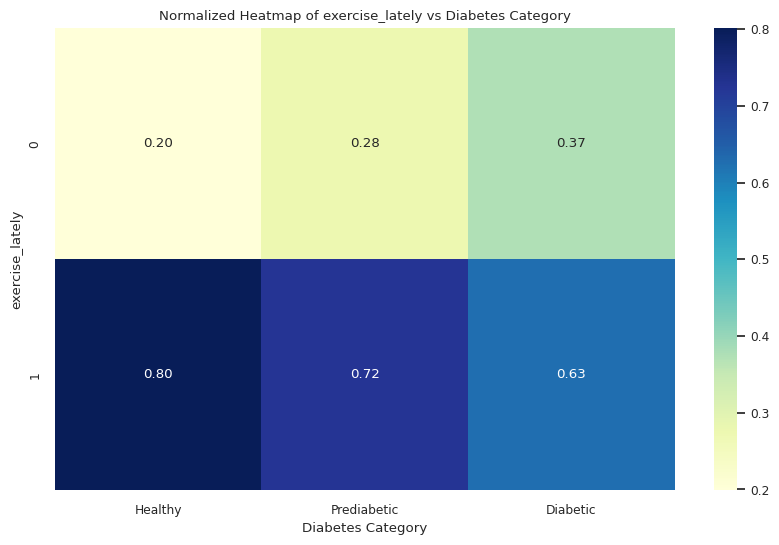

Column: exercise_lately
Chi-Square Statistic: 5077.323499555971
P-Value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[ 45284.4745111    3546.02809797   7224.49739093]
 [154739.5254889   12116.97190203  24686.50260907]]
There is a significant association between exercise_lately and diabetes type (reject H0)

--------------------------------------------------------------------------------



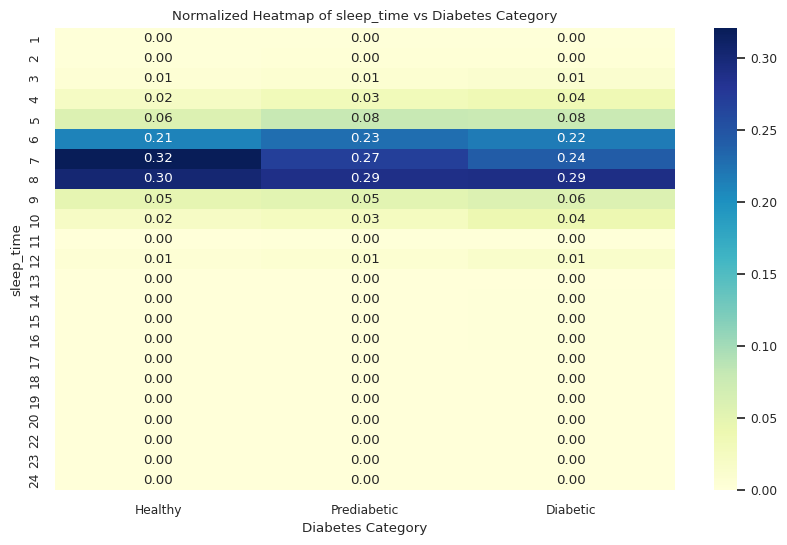

Column: sleep_time
Chi-Square Statistic: 2292.4003728197854
P-Value: 0.0
Degrees of Freedom: 44
Expected Frequencies:
[[3.27990307e+02 2.56834789e+01 5.23262143e+01]
 [4.91177602e+02 3.84619585e+01 7.83604391e+01]
 [1.23359901e+03 9.65977148e+01 1.96803274e+02]
 [4.94085891e+03 3.86896938e+02 7.88244154e+02]
 [1.23190251e+04 9.64648693e+02 1.96532621e+03]
 [4.25127141e+04 3.32898372e+03 6.78230222e+03]
 [6.14270910e+04 4.81008542e+03 9.79982353e+03]
 [5.98751960e+04 4.68856335e+03 9.55224063e+03]
 [9.90191426e+03 7.75375371e+02 1.57971037e+03]
 [4.77444018e+03 3.73865419e+02 7.61694400e+02]
 [2.55283096e+02 1.99900969e+01 4.07268072e+01]
 [1.36366413e+03 1.06782543e+02 2.17553324e+02]
 [6.70522056e+01 5.25056341e+00 1.06972310e+01]
 [1.47030138e+02 1.15132836e+01 2.34565788e+01]
 [1.15523680e+02 9.04615142e+00 1.84301691e+01]
 [1.38951559e+02 1.08806856e+01 2.21677558e+01]
 [1.53493001e+01 1.20193620e+00 2.44876372e+00]
 [5.49343371e+01 4.30166641e+00 8.76399648e+00]
 [3.23143159e+00 2

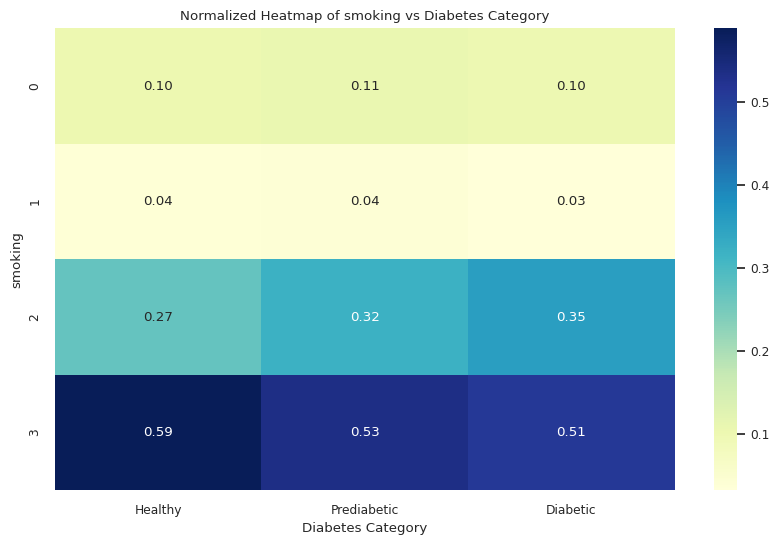

Column: smoking
Chi-Square Statistic: 1110.9478975092593
P-Value: 8.924631583266004e-237
Degrees of Freedom: 6
Expected Frequencies:
[[ 20562.40709537   1610.15169347   3280.44121116]
 [  7550.23992116    591.22609229   1204.53398654]
 [ 56848.96033086   4451.59213725   9069.44753189]
 [115062.39265261   9010.03007698  18356.57727041]]
There is a significant association between smoking and diabetes type (reject H0)

--------------------------------------------------------------------------------



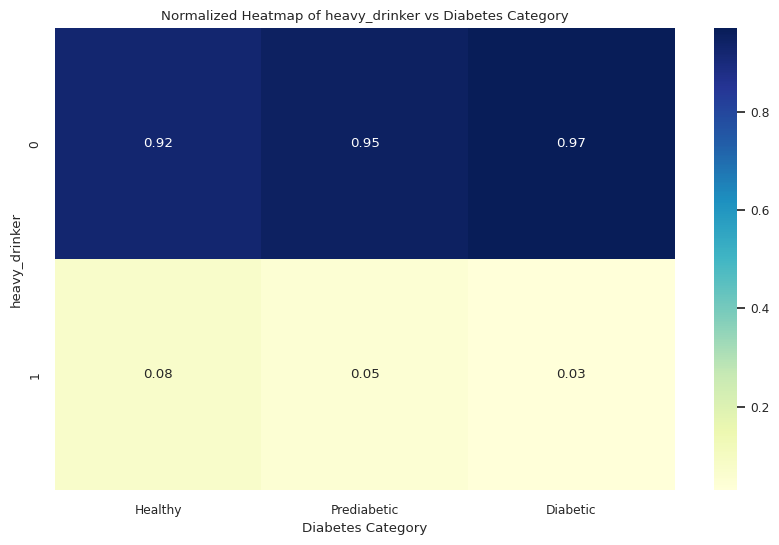

Column: heavy_drinker
Chi-Square Statistic: 1025.5338358732042
P-Value: 2.0330920287225874e-223
Degrees of Freedom: 2
Expected Frequencies:
[[186373.62508582  14594.0991567   29733.27575748]
 [ 13650.37491418   1068.9008433    2177.72424252]]
There is a significant association between heavy_drinker and diabetes type (reject H0)

--------------------------------------------------------------------------------



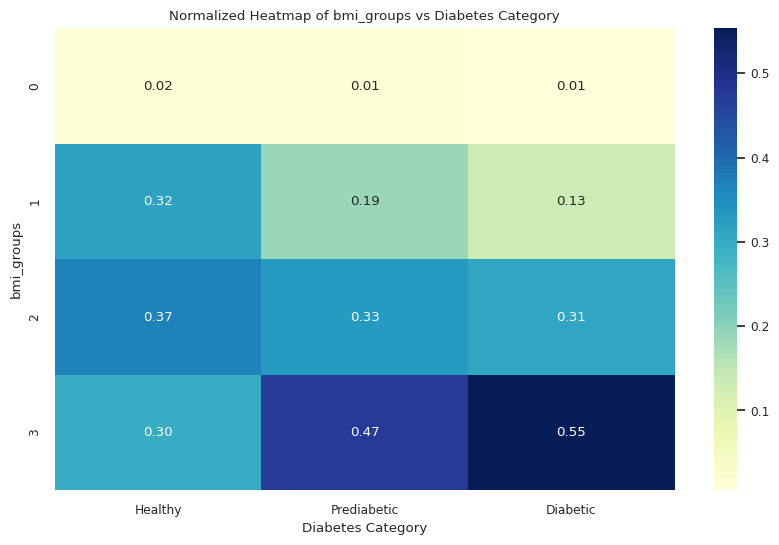

Column: bmi_groups
Chi-Square Statistic: 10501.445441798036
P-Value: 0.0
Degrees of Freedom: 6
Expected Frequencies:
[[ 2807.30619795   219.82780556   447.86599649]
 [57111.51414793  4472.15157231  9111.33427976]
 [71677.99991922  5612.78902899 11435.21105179]
 [68427.17973489  5358.23159315 10916.58867196]]
There is a significant association between bmi_groups and diabetes type (reject H0)

--------------------------------------------------------------------------------



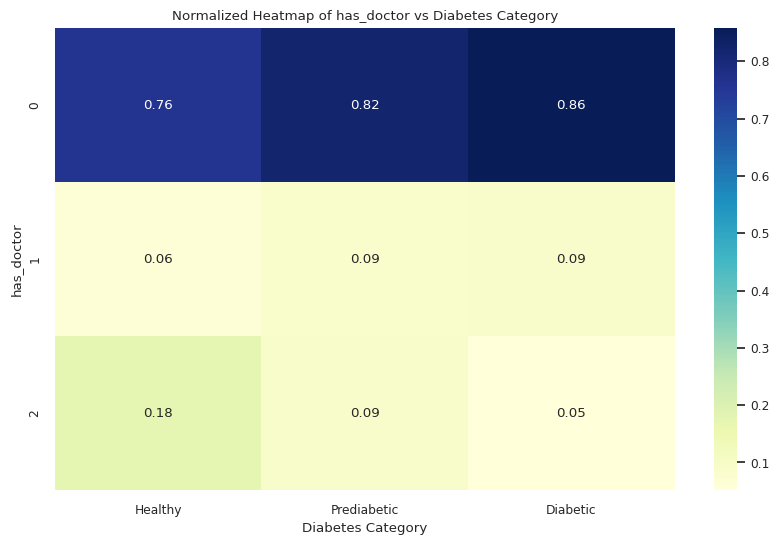

Column: has_doctor
Chi-Square Statistic: 3998.491099817258
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[155494.06476627  12176.05655538  24806.87867834]
 [ 13534.85123466   1059.85469188   2159.29407346]
 [ 30995.08399906   2427.08875274   4944.8272482 ]]
There is a significant association between has_doctor and diabetes type (reject H0)

--------------------------------------------------------------------------------



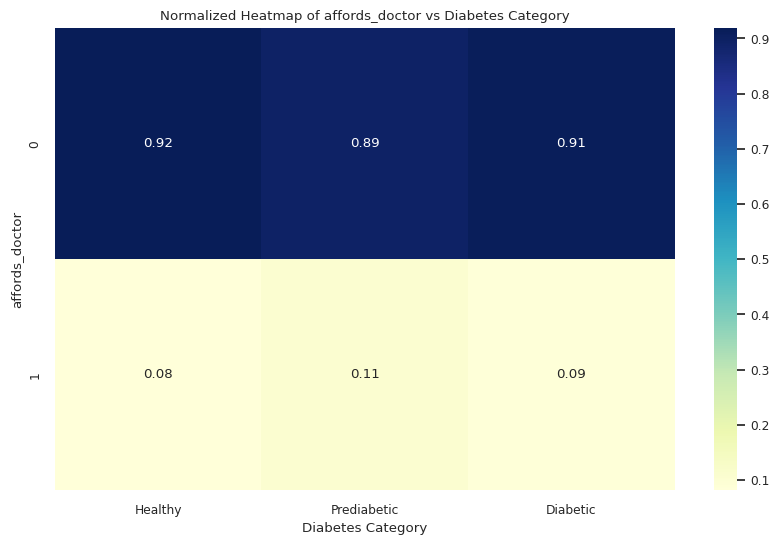

Column: affords_doctor
Chi-Square Statistic: 125.72048697622087
P-Value: 5.013524274127266e-28
Degrees of Freedom: 2
Expected Frequencies:
[[183272.25861275  14351.24478388  29238.49660337]
 [ 16751.74138725   1311.75521612   2672.50339663]]
There is a significant association between affords_doctor and diabetes type (reject H0)

--------------------------------------------------------------------------------



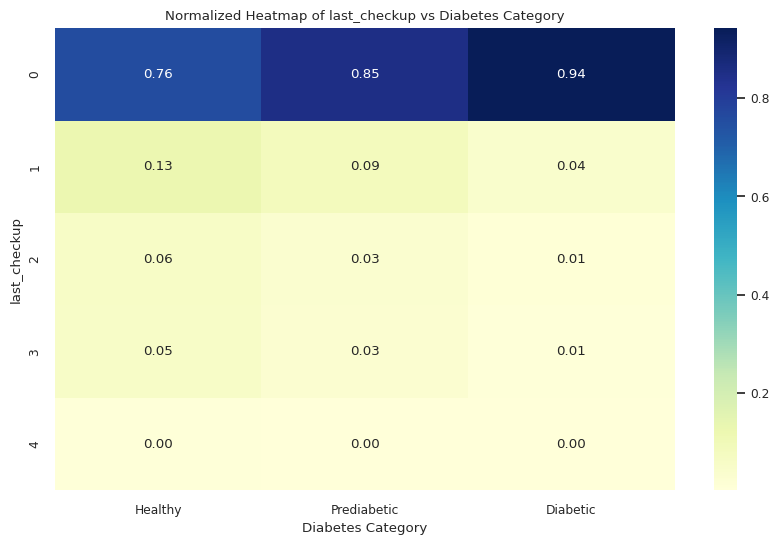

Column: last_checkup
Chi-Square Statistic: 6127.504867177053
P-Value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[1.57613076e+05 1.23419870e+04 2.51449370e+04]
 [2.23817031e+04 1.75261276e+03 3.57068415e+03]
 [1.01911274e+04 7.98022379e+02 1.62585023e+03]
 [8.99065055e+03 7.04018316e+02 1.43433113e+03]
 [8.47442936e+02 6.63595304e+01 1.35197534e+02]]
There is a significant association between last_checkup and diabetes type (reject H0)

--------------------------------------------------------------------------------



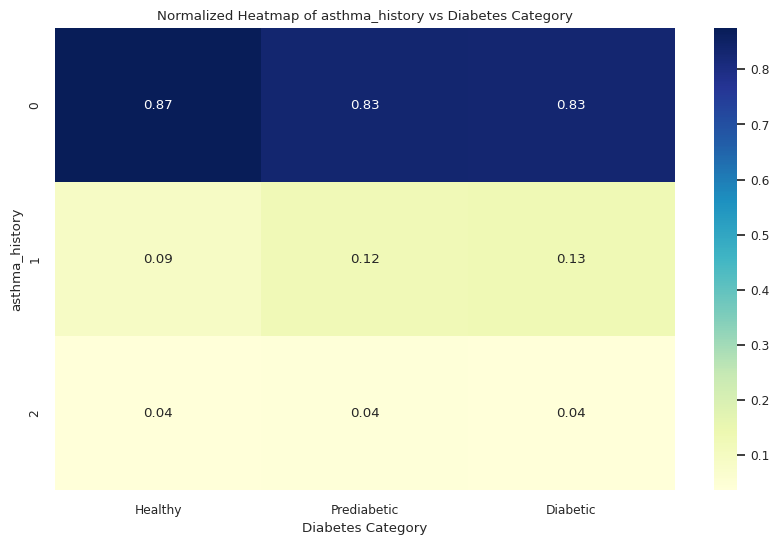

Column: asthma_history
Chi-Square Statistic: 787.95925922892
P-Value: 3.114551915399926e-169
Degrees of Freedom: 4
Expected Frequencies:
[[173258.05210058  13567.0763011   27640.87159832]
 [ 19385.35813698   1517.98216464   3092.65969838]
 [  7380.58976244    577.94153426   1177.4687033 ]]
There is a significant association between asthma_history and diabetes type (reject H0)

--------------------------------------------------------------------------------



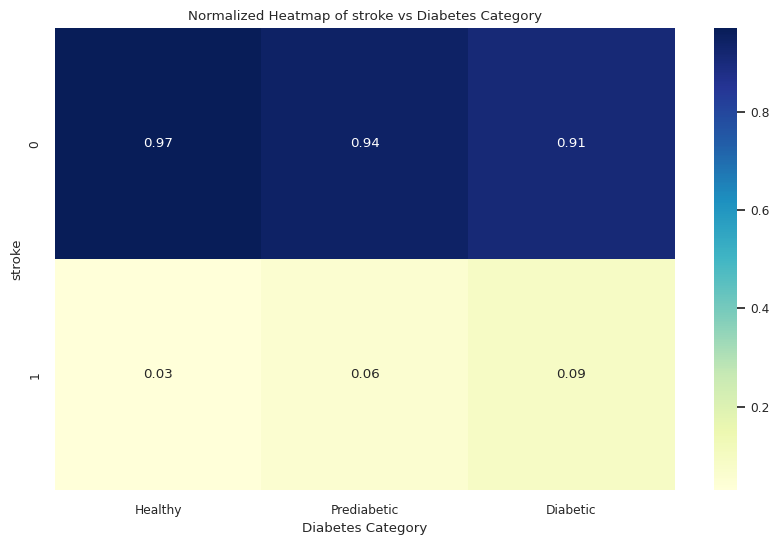

Column: stroke
Chi-Square Statistic: 2741.4353586704083
P-Value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[192127.1890403   15044.63545344  30651.17550626]
 [  7896.8109597     618.36454656   1259.82449374]]
There is a significant association between stroke and diabetes type (reject H0)

--------------------------------------------------------------------------------



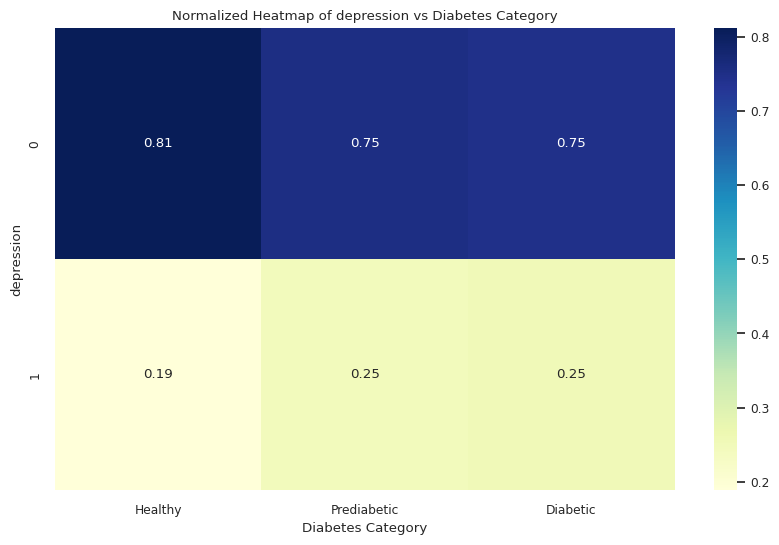

Column: depression
Chi-Square Statistic: 957.8573035523932
P-Value: 1.0090886195116312e-208
Degrees of Freedom: 2
Expected Frequencies:
[[159851.65027181  12517.27991745  25502.06981074]
 [ 40172.34972819   3145.72008255   6408.93018926]]
There is a significant association between depression and diabetes type (reject H0)

--------------------------------------------------------------------------------



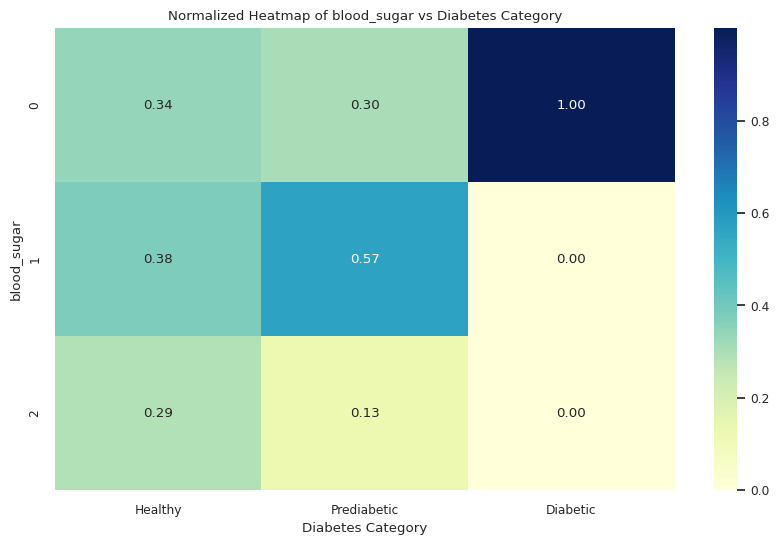

Column: blood_sugar
Chi-Square Statistic: 53783.26619895714
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[83902.50564221  6570.03632501 13385.45803278]
 [68412.63829272  5357.09291674 10914.26879054]
 [47708.85606507  3735.87075825  7611.27317668]]
There is a significant association between blood_sugar and diabetes type (reject H0)

--------------------------------------------------------------------------------



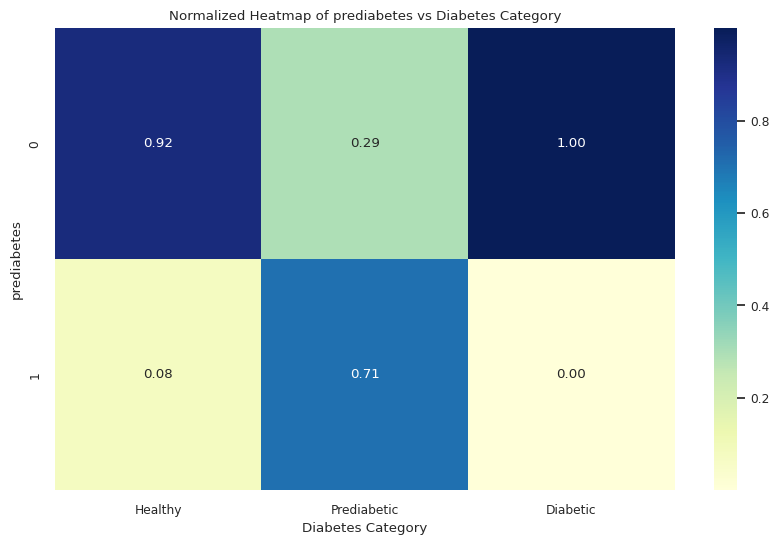

Column: prediabetes
Chi-Square Statistic: 65568.62026379944
P-Value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[178977.68602331  14014.95568623  28553.35829045]
 [ 21046.31397669   1648.04431377   3357.64170955]]
There is a significant association between prediabetes and diabetes type (reject H0)

--------------------------------------------------------------------------------



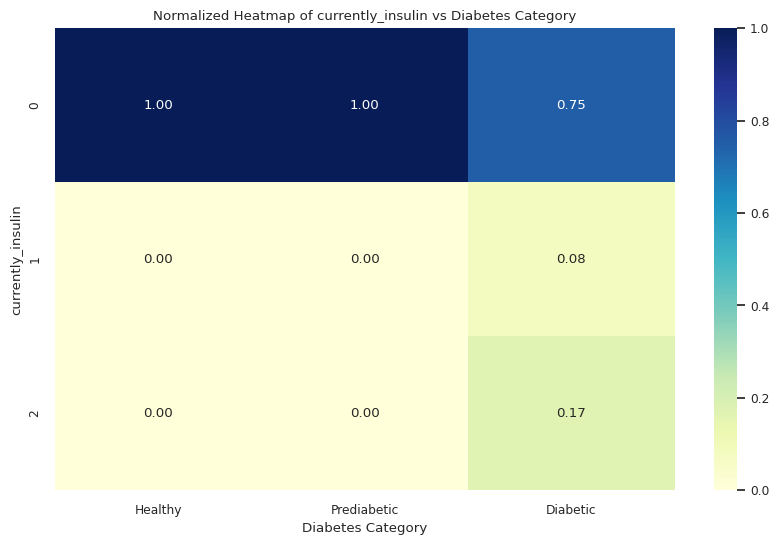

Column: currently_insulin
Chi-Square Statistic: 54954.16769822272
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[1.93664543e+05 1.51650189e+04 3.08964385e+04]
 [2.08992838e+03 1.63653103e+02 3.33418513e+02]
 [4.26952899e+03 3.34328044e+02 6.81142962e+02]]
There is a significant association between currently_insulin and diabetes type (reject H0)

--------------------------------------------------------------------------------



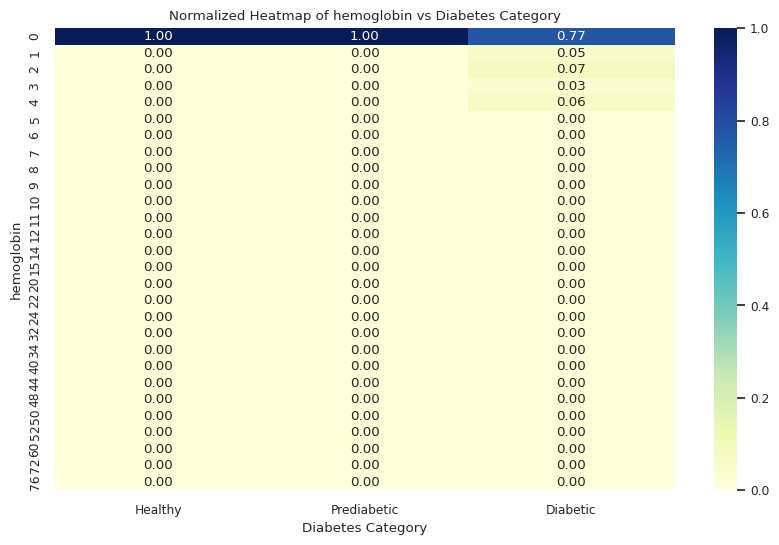

Column: hemoglobin
Chi-Square Statistic: 51026.34241935322
P-Value: 0.0
Degrees of Freedom: 54
Expected Frequencies:
[[1.94105633e+05 1.51995587e+04 3.09668083e+04]
 [1.26025832e+03 9.86852882e+01 2.01056390e+02]
 [1.91785465e+03 1.50178766e+02 3.05966583e+02]
 [8.16744336e+02 6.39556580e+01 1.30300006e+02]
 [1.61086865e+03 1.26140042e+02 2.56991308e+02]
 [7.18993530e+01 5.63012221e+00 1.14705248e+01]
 [8.88643689e+01 6.95857802e+00 1.41770531e+01]
 [8.88643689e+00 6.95857802e-01 1.41770531e+00]
 [7.27072109e+00 5.69338201e-01 1.15994071e+00]
 [5.65500529e+00 4.42818601e-01 9.02176108e-01]
 [1.69650159e+01 1.32845580e+00 2.70652832e+00]
 [8.07857899e-01 6.32598002e-02 1.28882301e-01]
 [7.75543583e+01 6.07294082e+00 1.23727009e+01]
 [1.61571580e+00 1.26519600e-01 2.57764602e-01]
 [3.23143159e+00 2.53039201e-01 5.15529205e-01]
 [4.03928949e+00 3.16299001e-01 6.44411506e-01]
 [1.61571580e+00 1.26519600e-01 2.57764602e-01]
 [5.65500529e+00 4.42818601e-01 9.02176108e-01]
 [8.07857899e-01 6.

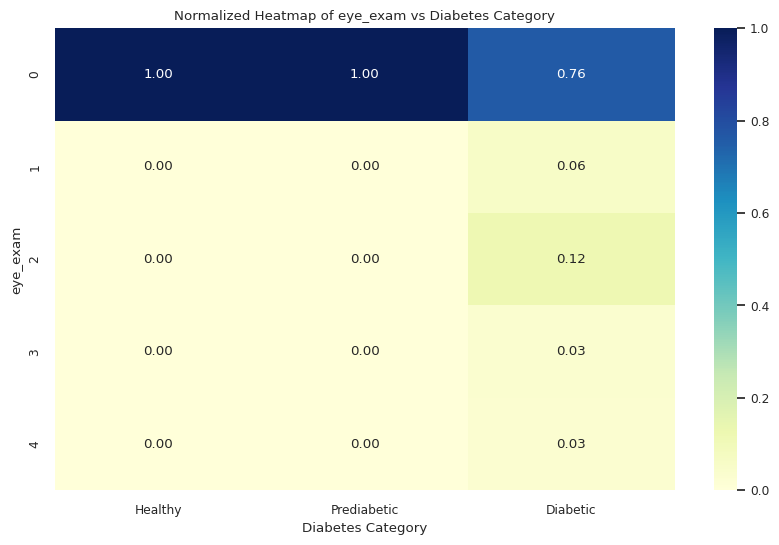

Column: eye_exam
Chi-Square Statistic: 53023.9908976457
P-Value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[1.93881049e+05 1.51819725e+04 3.09309790e+04]
 [1.43717920e+03 1.12539184e+02 2.29281614e+02]
 [3.04320070e+03 2.38299667e+02 4.85499628e+02]
 [8.94298694e+02 7.00285988e+01 1.42672707e+02]
 [7.68272862e+02 6.01600700e+01 1.22567068e+02]]
There is a significant association between eye_exam and diabetes type (reject H0)

--------------------------------------------------------------------------------



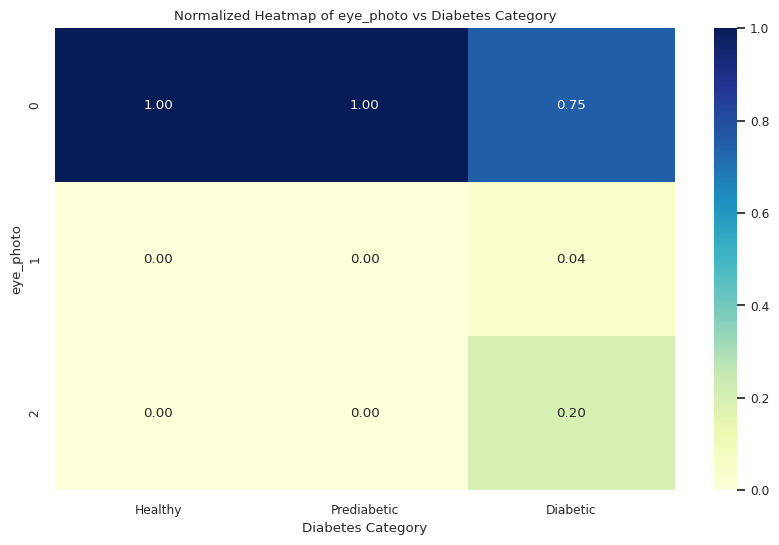

Column: eye_photo
Chi-Square Statistic: 54954.16769822272
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[1.93664543e+05 1.51650189e+04 3.08964385e+04]
 [1.15038965e+03 9.00819554e+01 1.83528397e+02]
 [5.20906773e+03 4.07899191e+02 8.31033078e+02]]
There is a significant association between eye_photo and diabetes type (reject H0)

--------------------------------------------------------------------------------



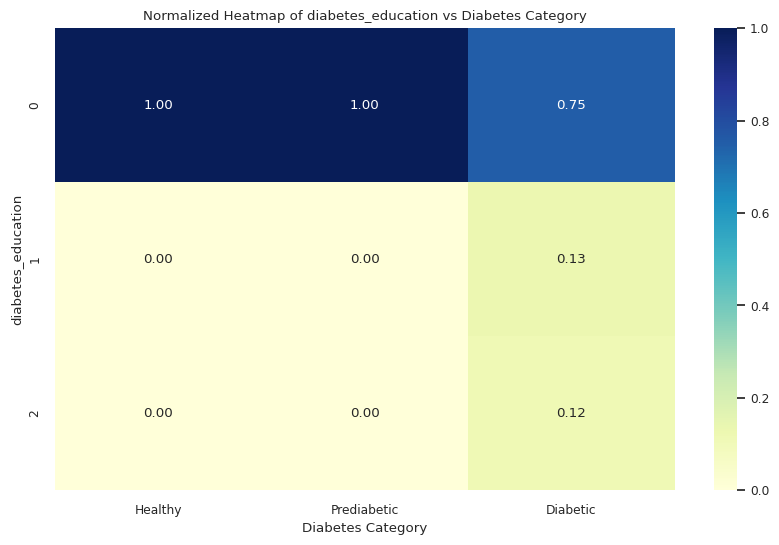

Column: diabetes_education
Chi-Square Statistic: 54954.16769822272
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[193664.54262151  15165.01885314  30896.43852535]
 [  3359.88100065    263.09750887    536.02149048]
 [  2999.57637784    234.88363799    478.53998417]]
There is a significant association between diabetes_education and diabetes type (reject H0)

--------------------------------------------------------------------------------



In [ ]:
from scipy.stats import chi2_contingency


categorical_columns = ['sleep_time', 'age_group', 'education', 'income_group', 'general_health', 'exercise_lately', 'smoking', 'affords_doctor', 'asthma_history']


# Labels for diabetes categories
diabetes_labels = ['Healthy', 'Prediabetic', 'Diabetic']

# Function to plot heatmap and perform chi-square test
def analyze_categorical_column(column_name):
    # Create contingency table
    contingency_table = pd.crosstab(inputs[column_name], inputs['diabetes'])

    # Create normalized contingency table for heatmap
    contingency_table_normalized = pd.crosstab(inputs[column_name], inputs['diabetes'], normalize='columns')

    # Plot the normalized heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(contingency_table_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=diabetes_labels, yticklabels=contingency_table.index)
    plt.xlabel('Diabetes Category')
    plt.ylabel(column_name)
    plt.title(f'Normalized Heatmap of {column_name} vs Diabetes Category')
    plt.show()



# Iterate over each categorical column and perform the analysis
for column in categorical_columns:
    analyze_categorical_column(column)

## **Socioeconomic Analysis**

**Ερώτηση:** Έστω η κατηγορία ανθρώπων που έχουν διαγνωστεί με διαβήτη ή προδιαβήτη. Ποιο το ποσοστό εκείνων που παρά τη διάγνωση τους συνεχίζει να κάνει δραστηριότητες που χειροτερεύουν την κατάσταση τους (όπως κατανάλωση αλκόολ, έλλειψη γυμναστικής, ελλειψη ύπνου, υψηλό bmi, κάπνισμα).  



In [ ]:
#individuals diagnosed with diabetes or prediabetes
diabetes_df = inputs[inputs['diabetes'].isin([1, 2])]

#  harmful activities
# Heavy drinking: heavy_drinker == 1
# Lack of exercise: exercise_lately == 0
# High BMI (overweight or obese): bmi_groups in [2, 3]
# Smoking a lot: smoking == 0

harmful_activities_df = diabetes_df[
    (diabetes_df['heavy_drinker'] == 1) |
    (diabetes_df['exercise_lately'] == 0) |
    (diabetes_df['bmi_groups'].isin([2, 3])) |
    (diabetes_df['smoking'] == 0)
]


total_diabetes = len(diabetes_df)
total_harmful = len(harmful_activities_df)
percentage_harmful = (total_harmful / total_diabetes) * 100

percentage_harmful


90.19842771261614

για συγκριση μπορούμε να εφαρμώσουμε το ίδιο query στους υγιής:

In [ ]:
#healthy individuals
diabetes_df = inputs[inputs['diabetes'].isin([0])]

harmful_activities_df = diabetes_df[
    (diabetes_df['heavy_drinker'] == 1) |
    (diabetes_df['exercise_lately'] == 0) |
    (diabetes_df['bmi_groups'].isin([2, 3])) |
    (diabetes_df['smoking'] == 0)
]


total_diabetes = len(diabetes_df)
total_harmful = len(harmful_activities_df)
percentage_harmful = (total_harmful / total_diabetes) * 100

percentage_harmful

76.5713114426269

Ερώτηση: Τι ποσοστό των ατόμων που έχουν διαγνωστεί με διαβήτη επηρρεάζονται από δυσμενής κοινωνικές και οικονιμικές συνθήκες?
Τέτοιες συνθήκες μπορεί να είναι:


*   όχι ασφάλεια υγείας
*   χαμηλό income group
*   μέλος εθνοτικής μειονότητας (όχι λευκοί)
*   πρόσβαση σε ιατροφαρμακευτική περίθαλψη





In [ ]:
import pandas as pd

# Assuming your DataFrame is named inputs

# Step 1: Filter for individuals who are diabetic (category 2)
diabetics_df = inputs[inputs['diabetes'] == 2]

# Step 2: Apply the socioeconomic filters
socioeconomic_filtered_df = diabetics_df[
    (diabetics_df['has_insurance'] == 0) |
    (diabetics_df['income_group'].isin([0, 1, 2])) |
    (diabetics_df['race'] != 0)
    #(diabetics_df['has_doctor'] == 2)
]

# Step 3: Calculate the percentage
total_diabetics = len(diabetics_df)
total_socioeconomic_filtered = len(socioeconomic_filtered_df)
percentage_socioeconomic_filtered = (total_socioeconomic_filtered / total_diabetics) * 100

percentage_socioeconomic_filtered



57.51621697847137

In [ ]:
healthy_df = inputs[inputs['diabetes'] == 0]

# Step 2: Apply the socioeconomic filters
socioeconomic_df = healthy_df[
    (healthy_df['has_insurance'] == 0) |
    (healthy_df['income_group'].isin([0, 1, 2])) |
    (healthy_df['race'] != 0)
    #(healthy_df['has_doctor'] == 2)
]

# Step 3: Calculate the percentage
total_healthy = len(healthy_df)
total_socioeconomic = len(socioeconomic_df)
percentage_socioeconomic = (total_socioeconomic / total_healthy) * 100

print(percentage_socioeconomic)


44.105207375114986
